## Introduction


### Time Series with External Regressors

This is a note on working with time series *with* external regressors, *and* specifying if the external regressors are treated as impermanent (short impulse response) or durable (long term impulse response).

The generative system we are interested in is the following with `y_auto` unobserved and `y` observed.

```
  y_auto[i] ~ b_auto_intercept + b_auto . (y_auto[i-l1], ..., y_auto[i-lk])
  y[i] ~ y_auto[i] + b_x . x[i]
```

Where l1, ..., lk are our lags, and x[] is the external regressors.

We will call external regressors that do not contribute to future time indices (as above) "impermanent". Our data will be so generated, and we will see models that are structured to expect this structure outperform models that are not so structured. We will call any external regressors in the `y_auto` series "durable" as they (indirectly) affect future measurements. We will call a model that matches the structure of the assumed data generating process as "structure respecting", and one that does not as "disrespecting." Having a good guess of the model structure is a positive and useful inductive bias.

The above distinction is dealing with durable AR (or auto-regressive, or infinite impulse response) issues in external regressors (in addition to AR issues in observations), and impermanent MA (or "moving average", though the term merely means finite impulse response in time series work- not an actual "moving average").

On terminology: from Box, Jenkins, Reinsel, *Time Series Analysis: Forecasting and Control*, 4th Edition, Wiley, 2008 (Introduction p. 10) we have the following.

> The name "moving average" is somewhat misleading because the weights 1, -&theta;<sub>1</sub>, -&theta;<sub>2</sub>, ... -&theta;<sub>q</sub>, which multiply the a's need not total to unity nor need they be positive. However, this nomenclature is in common use, and therefore we employ it.

## Setting up our example

In [1]:
# set up Python
import logging
import numpy as np
import pandas as pd
from plotnine import *

from nested_model_fns import (
    build_example, 
    train_test_split, 
    define_Stan_model_with_forecast_period, 
    solve_forecast_by_Stan,
    plot_forecast,
    extract_sframe_result,
    plot_model_quality,
    plot_model_quality_by_prefix,
    plot_recent_state_distribution,
    plot_hidden_state_estimate,
    apply_linear_model_bundle_method,
)

# quite down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())

In [2]:
rng = np.random.default_rng(383432)


Our example data is as follows.

In [3]:
# specify example
generating_lags = (1, 2)
gen_scale = 5.2
gen_shift = 10.0
b_auto = (2 * np.cos(np.pi/20), -1)  # angle addition
b_auto_intercept = gen_scale * gen_shift * (1 - np.sum(b_auto))
# external regressor
b_x = (8.1, )

generating_params = {
    'b_auto_intercept': b_auto_intercept,
    'b_auto': b_auto,
    'b_x': b_x,
}

# show original generative parameters
generating_params


{'b_auto_intercept': 1.2804125781056719,
 'b_auto': (1.9753766811902755, -1),
 'b_x': (8.1,)}

In [4]:
# build the example
d_example = build_example(
    rng=rng,
    generating_lags=generating_lags,
    b_auto=b_auto,
    b_auto_intercept=b_auto_intercept,
    b_x=b_x,
)
d_example['x_0_value'] = [str(v) for v in d_example['x_0']]


In [5]:
# split into test and train by time
d_train, d_test = train_test_split(d_example)


In [6]:
# show training data
d_train


,time_tick,x_0,y,x_0_value
0,0,0,52.356067,0
1,1,0,51.320189,0
2,2,0,51.220962,0
3,3,1,57.646062,1
4,4,1,57.632508,1
...,...,...,...,...
945,945,1,51.823500,1
946,946,1,53.682440,1
947,947,0,48.013500,0
948,948,0,49.270920,0


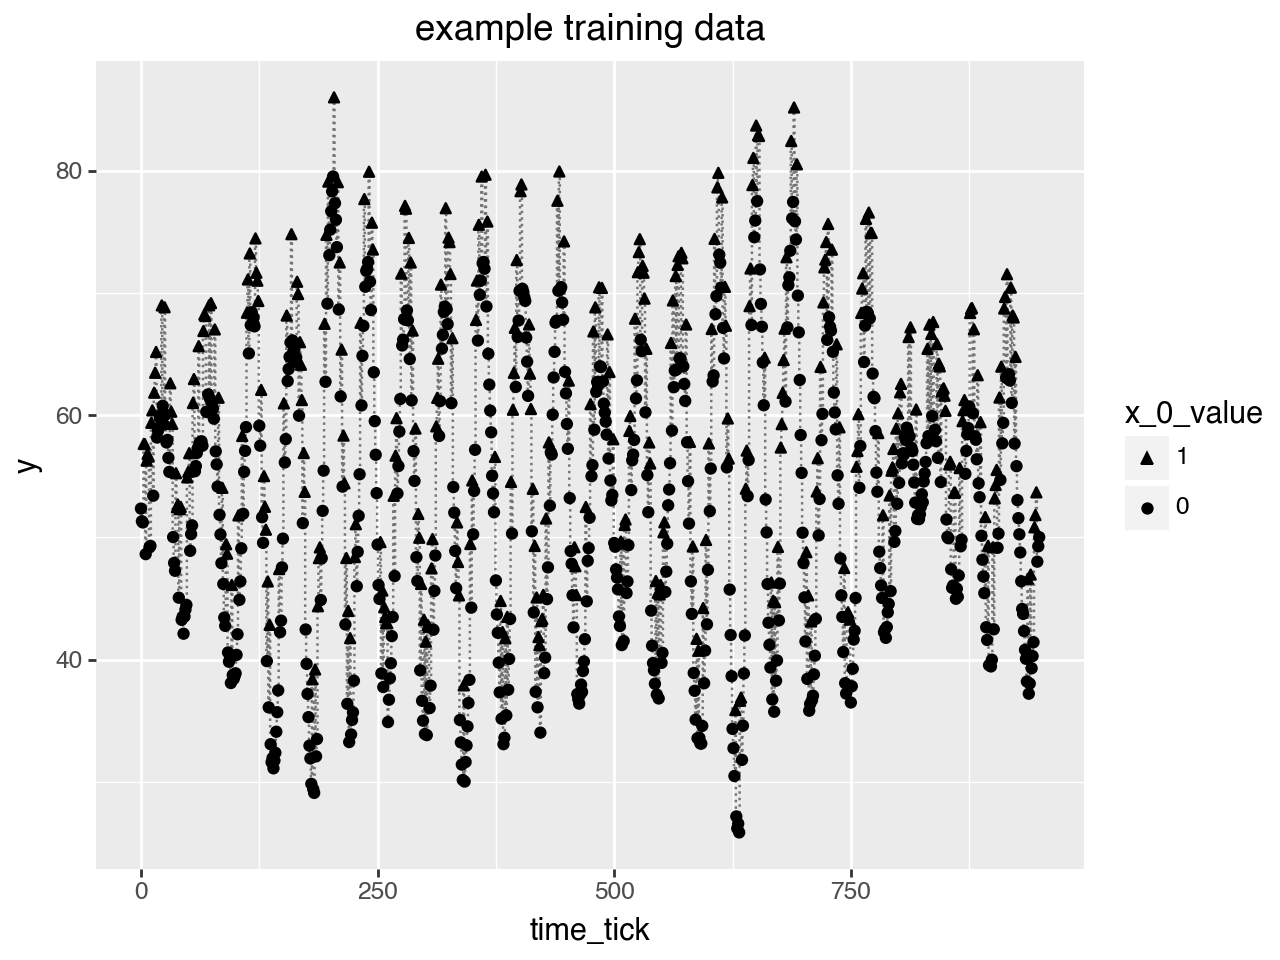

In [7]:
# plot training data
(
    ggplot(
        data=d_train,
        mapping=aes(x='time_tick', y='y')
    )
    + geom_step(alpha=0.5, direction='mid', linetype='dotted')
    + geom_point(mapping=aes(shape='x_0_value'))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example training data")
)


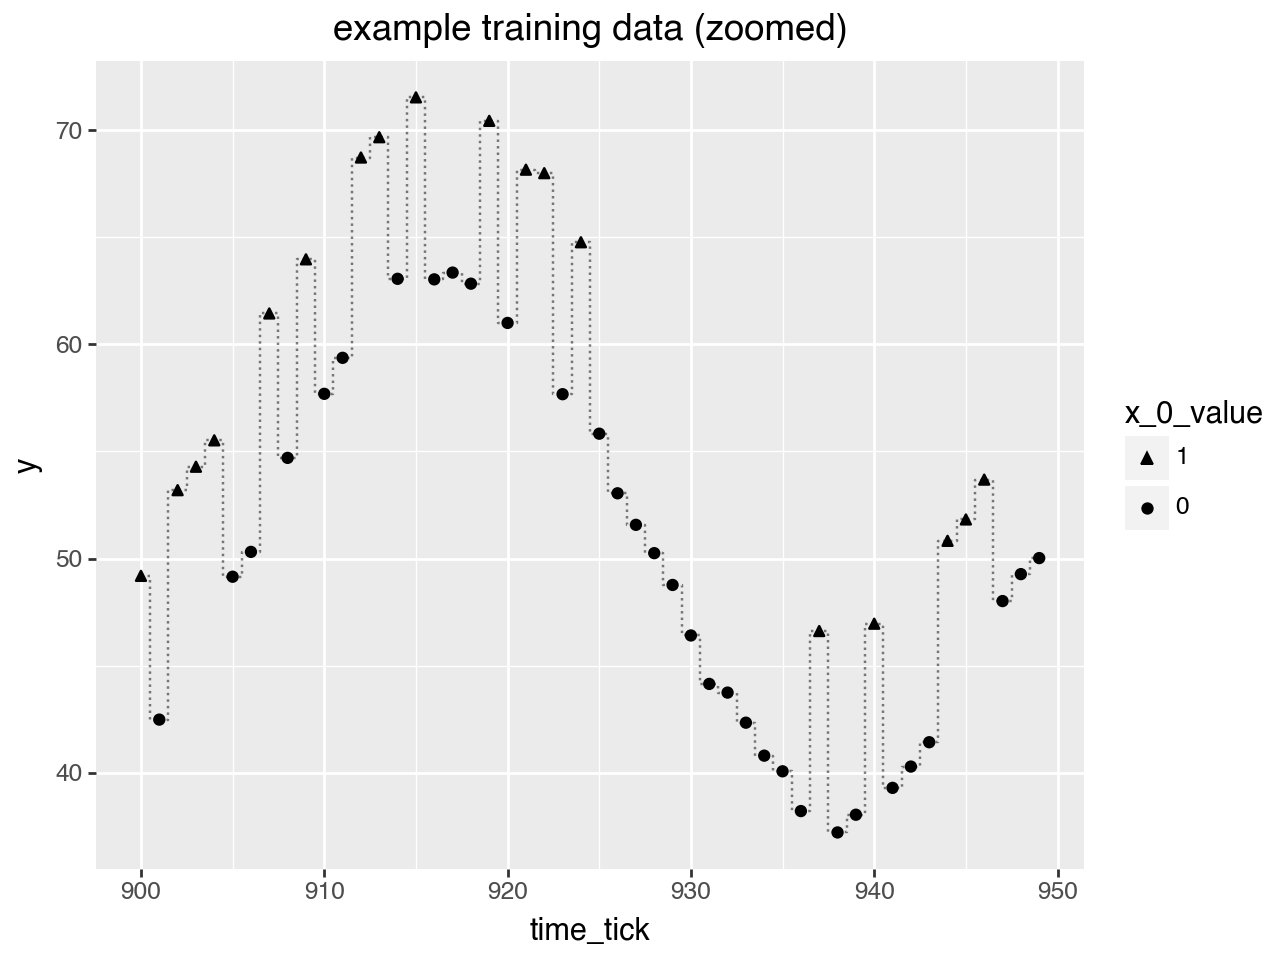

In [8]:
# zoom in on training data and annotate
d_train_zoomed = d_train.loc[
    d_train['time_tick'] >= (d_train.shape[0] - d_test.shape[0]), 
    :].reset_index(drop=True, inplace=False)
(
    ggplot(
        data=d_train_zoomed,
        mapping=aes(x='time_tick', y='y')
    )
    + geom_step(alpha=0.5, direction='mid', linetype='dotted')
    + geom_point(mapping=aes(shape='x_0_value'))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example training data (zoomed)")
)


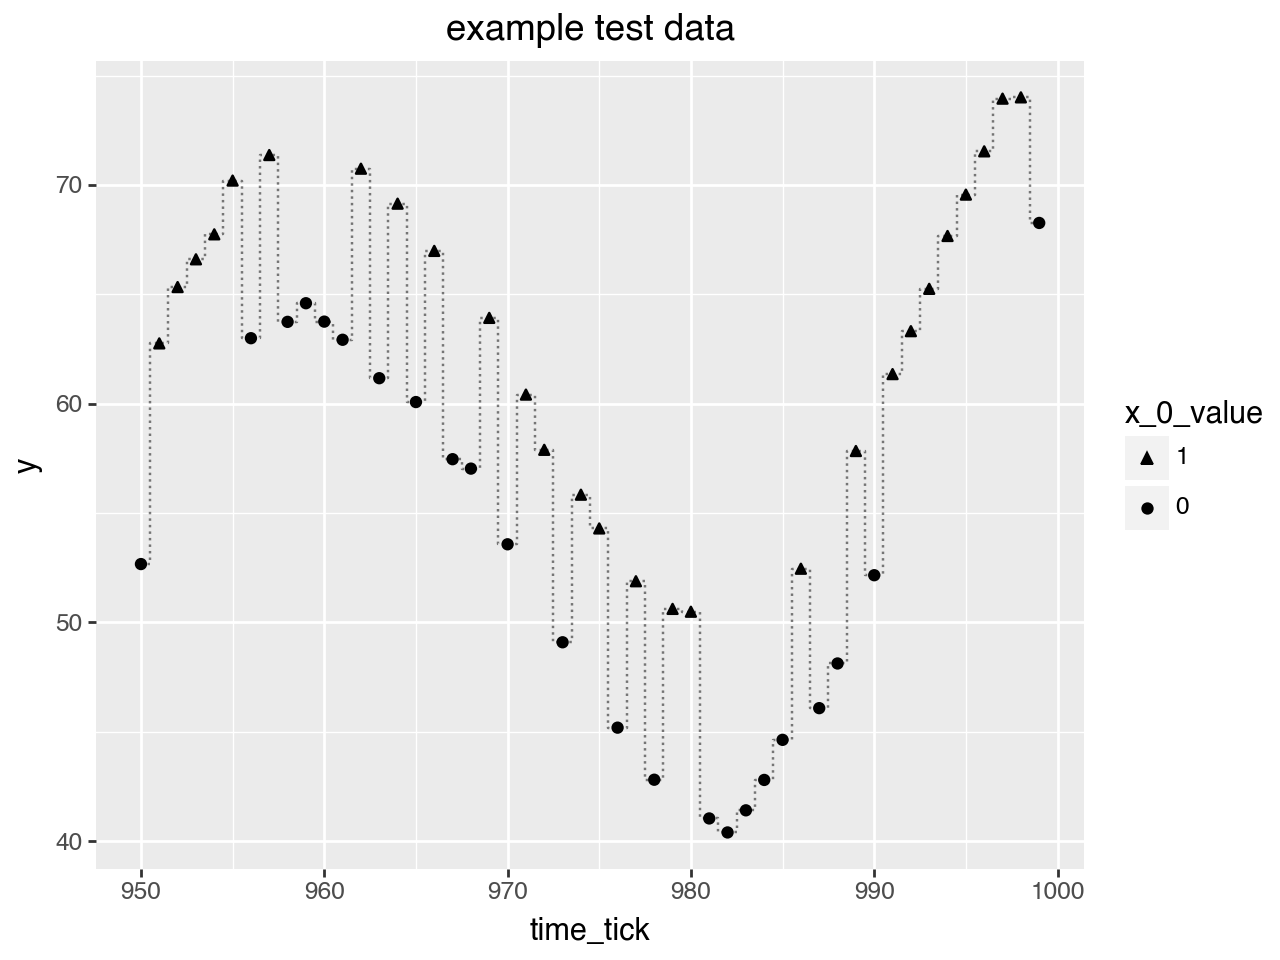

In [9]:
# plot test data
(
    ggplot(
        data=d_test,
        mapping=aes(x='time_tick', y='y')
    )
    + geom_step(alpha=0.5, direction='mid', linetype='dotted')
    + geom_point(mapping=aes(shape='x_0_value'))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example test data")
)


## Ignoring External Regressors

Now, let's demonstrate attempting to fit a direct linear model bundle, without external regressors. In this a linear model bundle is a bundle of models which for each <code>k &ge; 0</code>, we predict <code>y[i + k] ~ g(x[i + k]) + f(y[i-l1], y[i-l2], ..., y[i-lk])</code>. The <code>li</code> are positive date/time index lags, and <code>g()</code>, and <code>f()</code> are linear functions to be fit. This formulation is simple, but not quite structure respecting- as the external regressors are modeled as having a durable effect.

In the first case we have no external regressors, so this is <code>y[i + k] ~ f(y[i-l1], y[i-l2], ..., y[i-lk])</code>.


In [10]:
d_test['linear model bundle (no external regressors)'] = apply_linear_model_bundle_method(
    modeling_lags=generating_lags,
    external_regressors = [],
    d_train=d_train,
    d_apply=d_test,
    pull_off_external_effects=False,
)


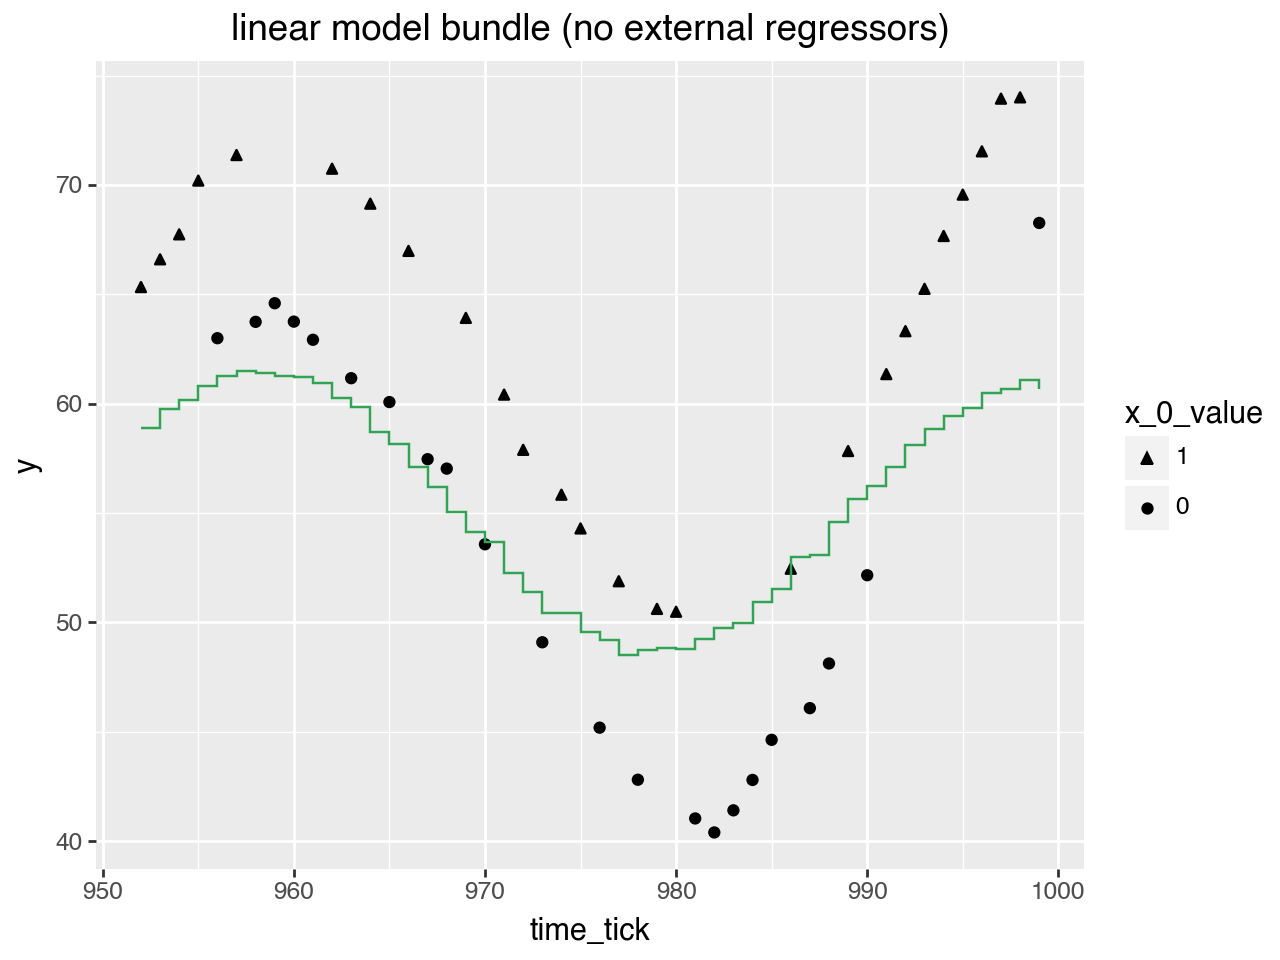

In [11]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis='columns'), :],
        mapping=aes(x='time_tick')
    )
    + geom_point(aes(y='y', shape='x_0_value'))
    + geom_step(
        aes(y='linear model bundle (no external regressors)'),
        color='#31a354')
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("linear model bundle (no external regressors)")
)


As the model has no access the external regressors, it can't take advantage of them and is forced to pick a "mid-path" through previous training data. This path then deviates a lot in out of sample test data, as the un-modeled effect of the external regressors also obscures important forward relations.

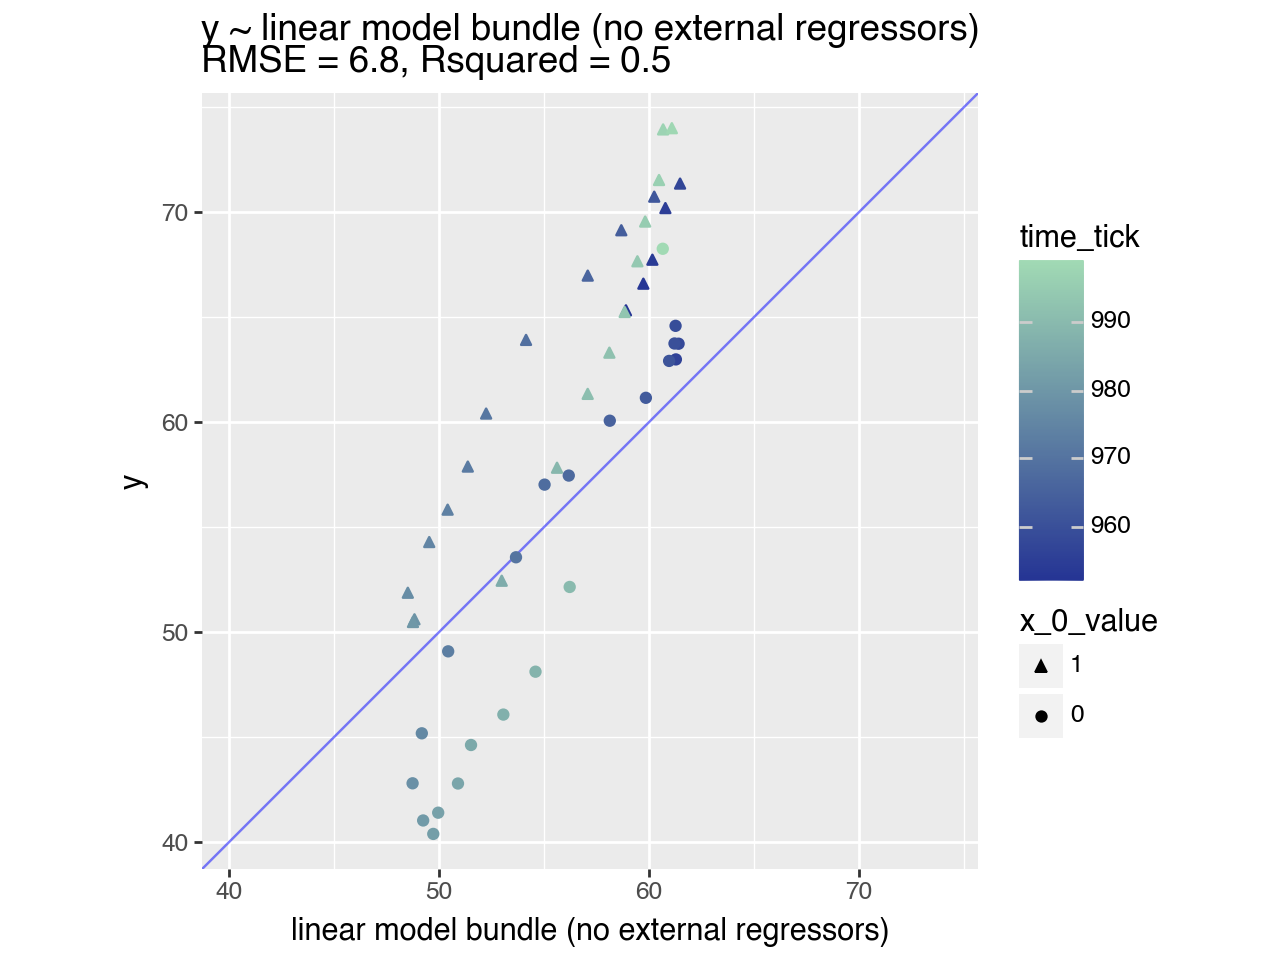

In [12]:
plot_model_quality(
    d_test.loc[pd.isnull(d_test['linear model bundle (no external regressors)']) == False, :],
    result_name='linear model bundle (no external regressors)',
)


## Adding in external regressors simplest try (not respecting problem domain structure)

Another thing to try is a linear model bundle with jointly estimated (or, unfortunately, non-structure respecting durable) external regressor effects. We show that here.


In [13]:
d_test['linear model bundle (durable external regressors)'] = apply_linear_model_bundle_method(
    modeling_lags=generating_lags,
    external_regressors = ['x_0'],
    d_train=d_train,
    d_apply=d_test,
    pull_off_external_effects=False,
)


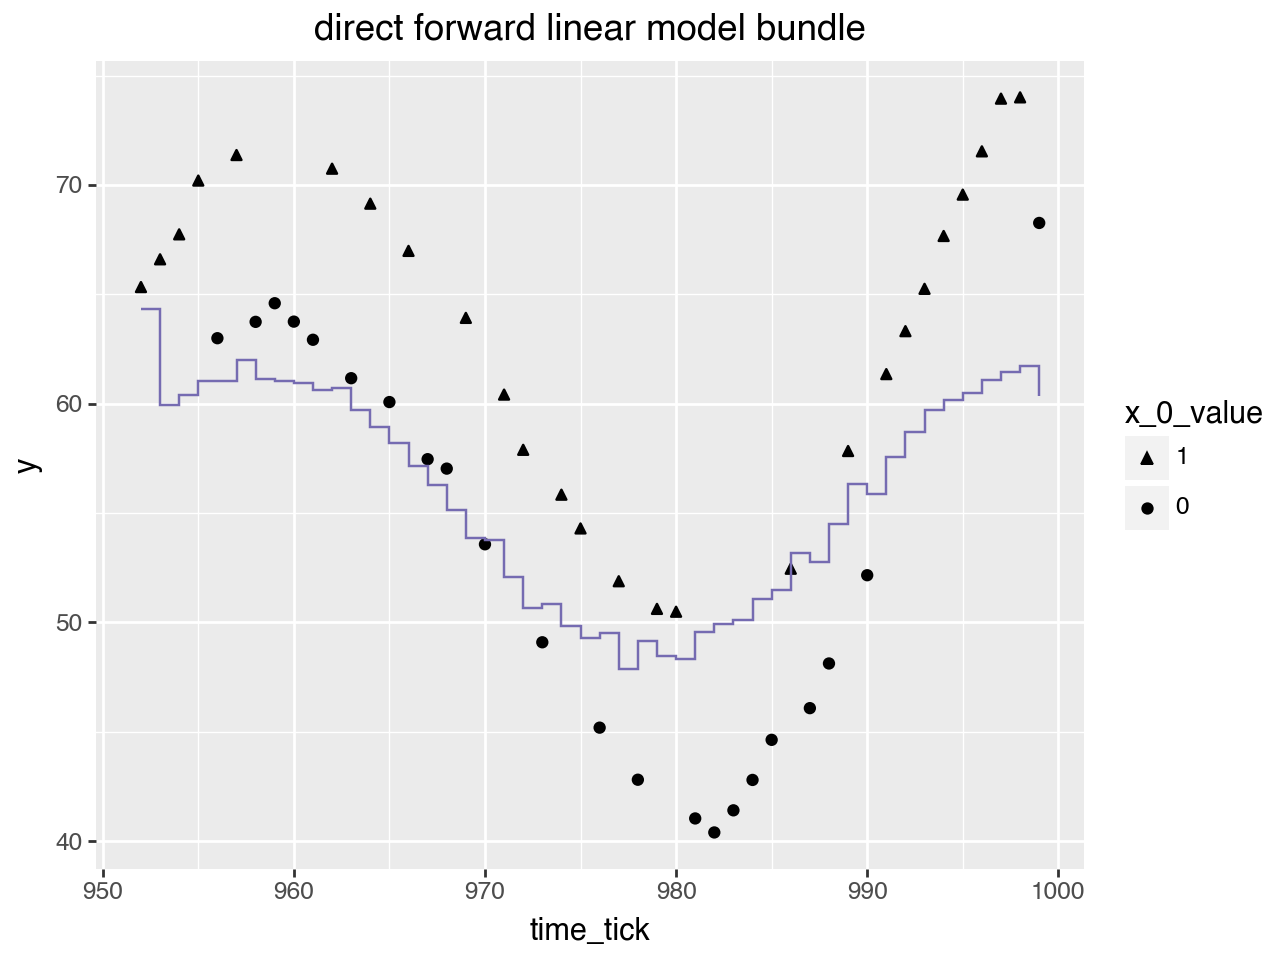

In [14]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis='columns'), :],
        mapping=aes(x='time_tick')
    )
    + geom_point(aes(y='y', shape='x_0_value'))
    + geom_step(aes(y='linear model bundle (durable external regressors)'), color='#756bb1')
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("direct forward linear model bundle")
)


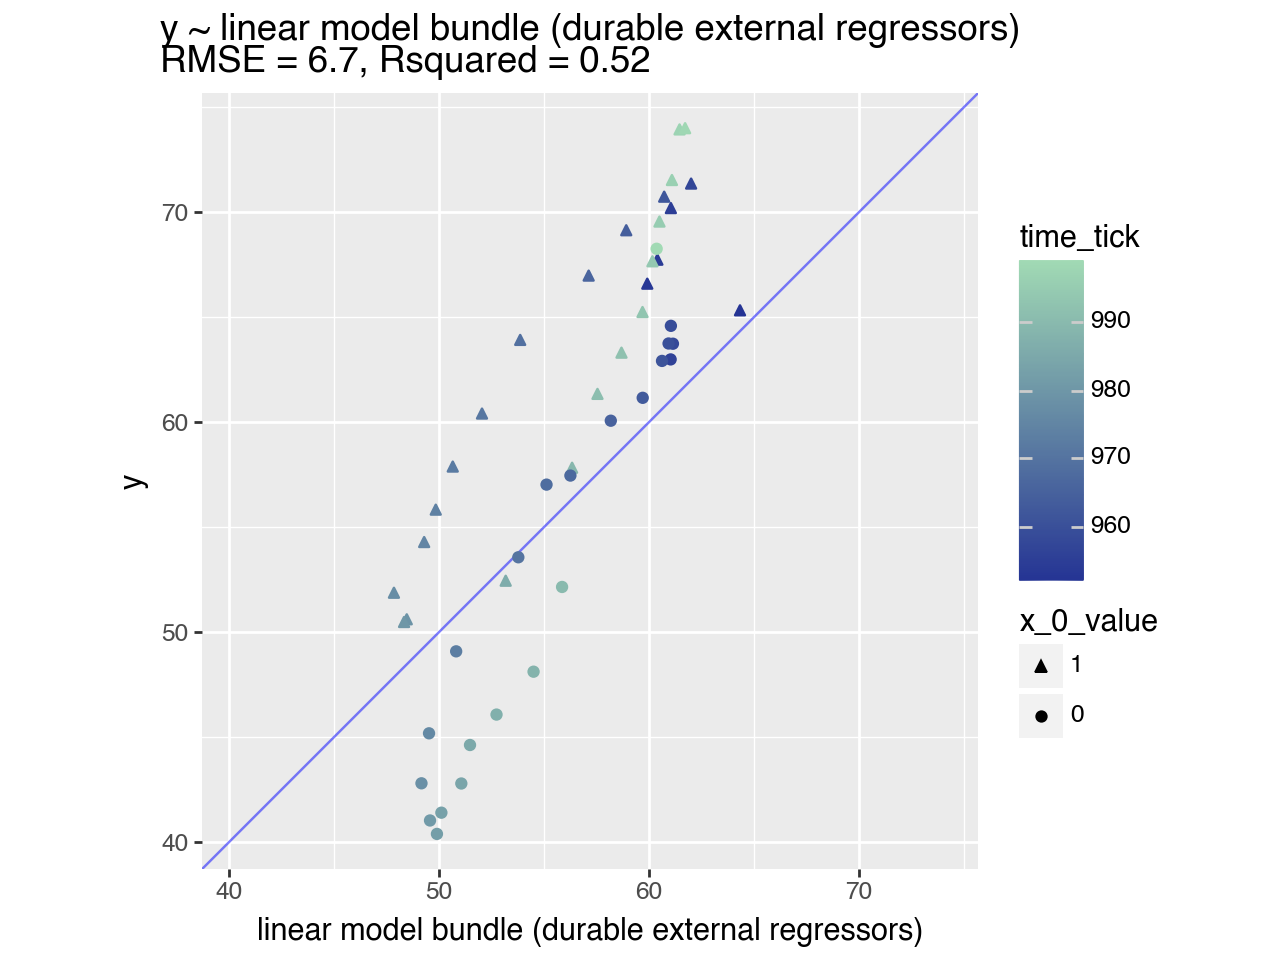

In [15]:
plot_model_quality(
    d_test.loc[pd.isnull(d_test['linear model bundle (durable external regressors)']) == False, :],
    result_name='linear model bundle (durable external regressors)',
)


This model has *slightly() better quality, but is not picking up all of the signal.

## Adding external regressors compatible with stated problem structure

Now we try a linear model with a subtracted (pulled-off) pre-estimate of external regressors. This is an attempt to respect the expected impermanent nature of the external regressors. The estimation method is a bit ad-hoc (being an uncorrected nested model estimate), but turns out to be quite powerful.


In [16]:
d_test['linear model bundle (subtracted external regressor estimate)'] = apply_linear_model_bundle_method(
    modeling_lags=generating_lags,
    external_regressors = ['x_0'],
    d_train=d_train,
    d_apply=d_test,
    pull_off_external_effects=True,
)


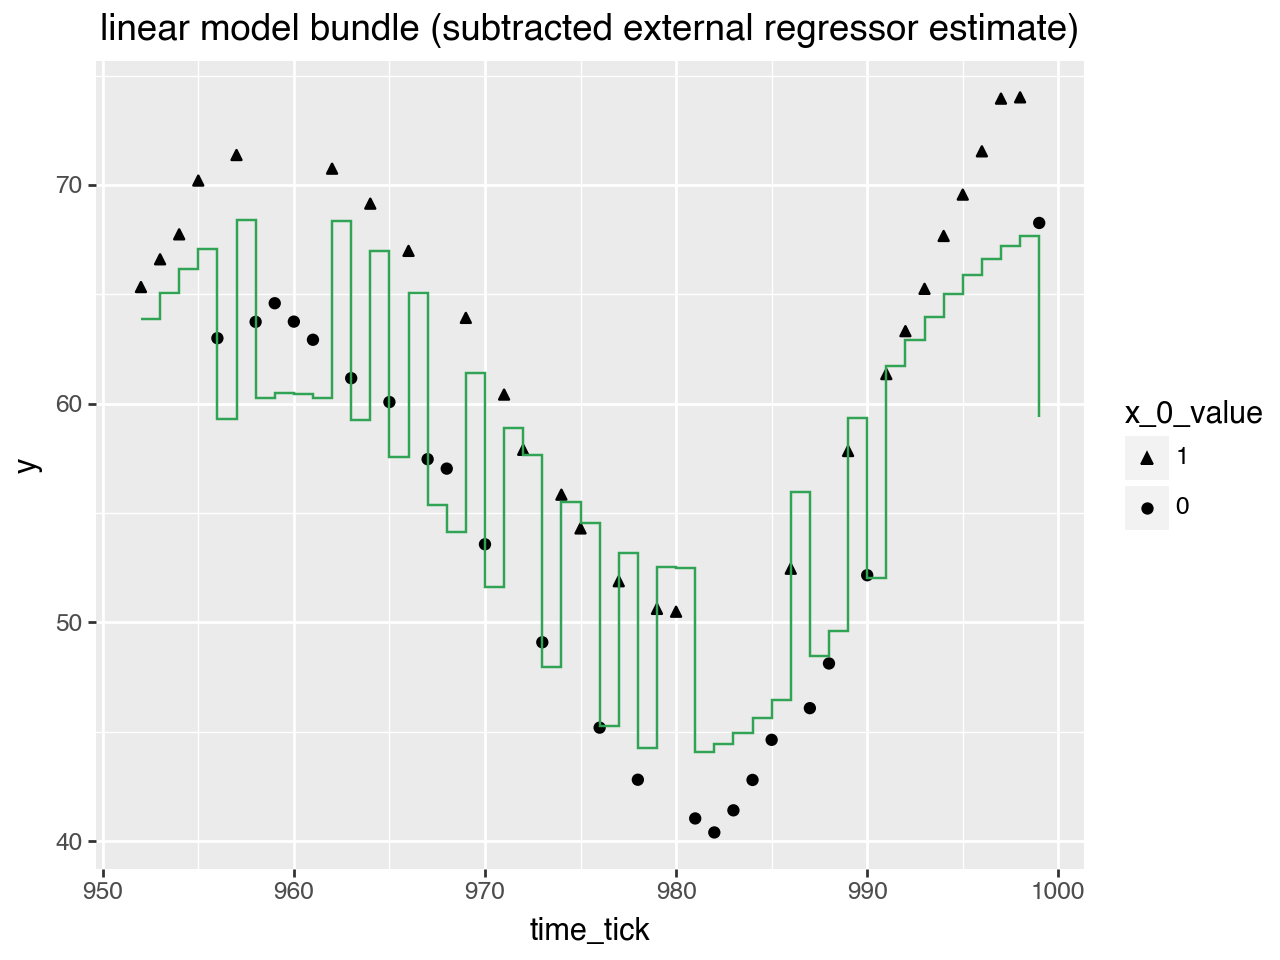

In [17]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis='columns'), :],
        mapping=aes(x='time_tick')
    )
    + geom_point(aes(y='y', shape='x_0_value'))
    + geom_step(
        aes(y='linear model bundle (subtracted external regressor estimate)'),
        color='#31a354')
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("linear model bundle (subtracted external regressor estimate)")
)


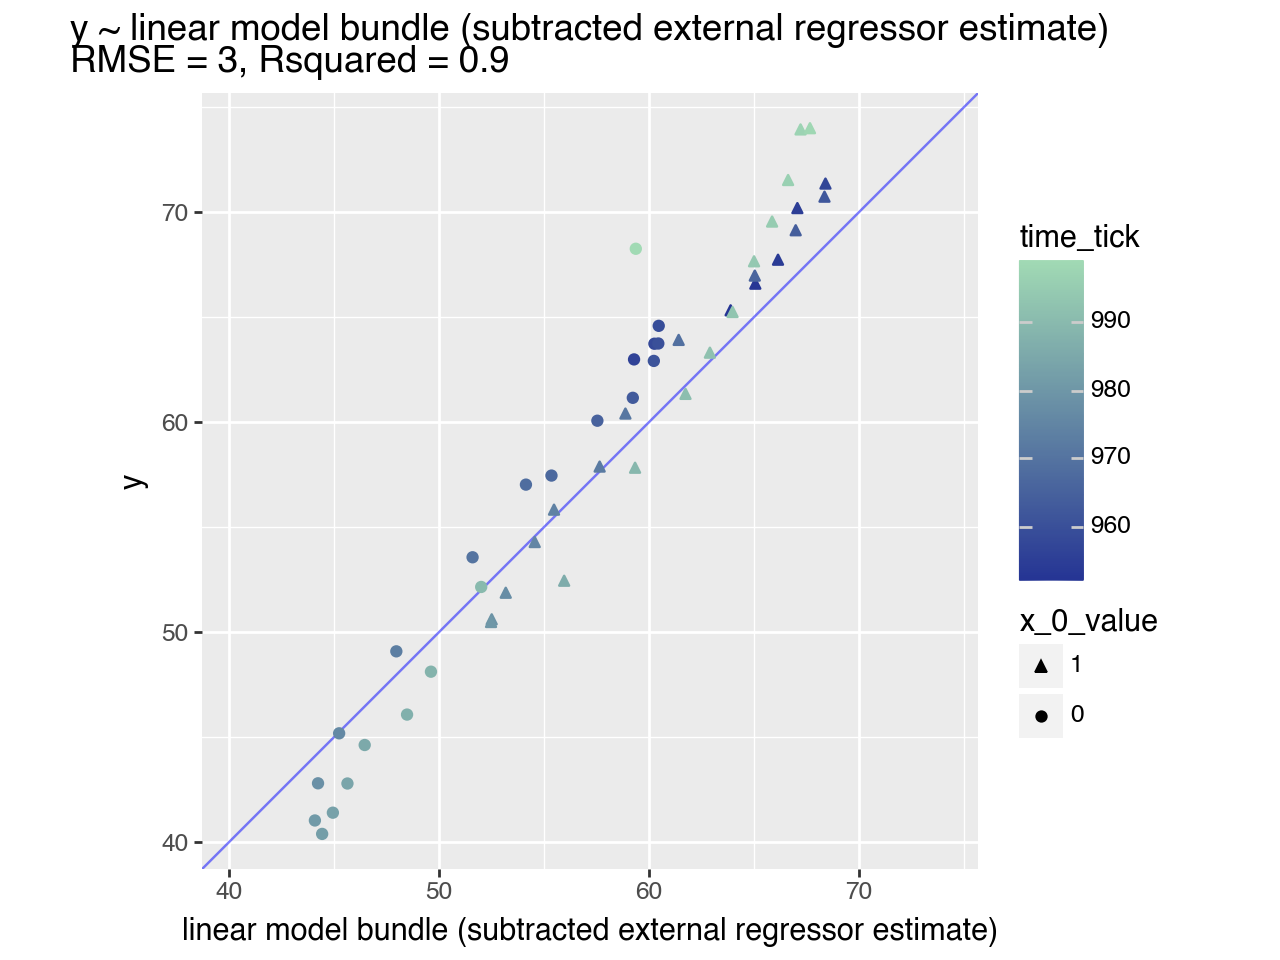

In [18]:
plot_model_quality(
    d_test.loc[pd.isnull(d_test['linear model bundle (subtracted external regressor estimate)']) == False, :],
    result_name='linear model bundle (subtracted external regressor estimate)',
)


The above can be done properly with an ARX model of section 2.2.1.2 pp.21-22 of Gianluigi Pillonetto , Tianshi Chen , Alessandro Chiuso , Giuseppe De Nicolao , Lennart Ljung *Regularized System Identification*, Springer 2022 (open access link: https://link.springer.com/book/10.1007/978-3-030-95860-2 ). This is just linear regression with additional equality constraints (to match the lag structure of the external regressors and observed outcomes).

## Solving again with the Bayesian "big hammer"

As an "upper bound" on how good a forecast we can make from such data, we try a Bayesian model with the correct generative structure, using the [Stan](https://mc-stan.org/users/interfaces/cmdstan) software package.



In [19]:
# define a Stan model for both impermanent external regressors and future predictions
stan_model_with_forecast_i, stan_model_with_forecast_src_i = define_Stan_model_with_forecast_period(
    application_lags=generating_lags,
    n_impermanent_external_regressors=len(b_x),
)


In [20]:
# show the model specification
print(stan_model_with_forecast_src_i)



data {
  int<lower=1> N_y_observed;                  // number of observed y outcomes
  int<lower=1> N_y_future;                    // number of future outcomes to infer
  vector[N_y_observed] y_observed;            // observed outcomes
  vector[N_y_observed + N_y_future] x_imp_1;  // observed impermanent external regressor
}
parameters {
  real b_auto_intercept;                      // auto-regress intercept
  vector[2] b_auto;                           // auto-regress coefficients
  vector[1] b_x_imp;                          // impermanent external regressor coefficients
  vector[N_y_future] y_future;                // to be inferred future state
  vector[N_y_observed + N_y_future] y_auto;   // unobserved auto-regressive state
  real<lower=0> b_var_y_auto;                 // presumed y_auto (durable) noise variance
  real<lower=0> b_var_y;                      // presumed y (impermanent) noise variance
}
transformed parameters {
        // y_observed and y_future in one notation (f

`y` and `y_auto` are supposed to be non-negative (a constraint we have chosen to *not* enforce, as it degraded results, probably by damaging sampling paths) it is tempting to try a non-negative distribution statements such as <code>y .* y ~ gamma(&alpha; = f(y_auto, x)<sup>4</sup> / &sigma;<sup>2</sup>, &beta; = f(y_auto, x)<sup>2</sup> / &sigma;<sup>2</sup>)</code>. This, in practice, turns out to be a bad idea.

Please keep in mind a distributional statement such as <code>y ~ normal(f(y_auto, x), &sigma;<sup>2</sup>)</code> is actually modeling the residual <code>(y - f(y_auto, x))</code> as being distributed <code>normal(0, &sigma;<sup>2</sup>)</code>. So the above model-block statements are distributional assumptions about *residuals*, as the intended mean is an input to these statements. Thus we are specifying a normal distribution for residuals, not a normal distribution for expected values or predictions. I feel the normal approximation for `y`'s residual is not that bad. A similar statement can be made for `y_auto`'s residuals.

All in all: specifying systems to Stan is a compromise in respecting problem structure, and preserving the ability to effectively sample. The specification tends to requires some compromise and experimentation. In my opinion, it isn't quite the case that "Bayes' Law names only one legitimate inferential network and we can then use that one!" One is going to have to specify an approximate system. It becomes the user's responsibility to design for a (hopefully) high utility tradeoff between fidelity and realizability.


What Stan generates is: thousands of possible trajectories of parameters, and past and future hidden state.

In [21]:
# sample from Stan model solutions
forecast_soln_i = solve_forecast_by_Stan(
    model=stan_model_with_forecast_i,
    d_train=d_train,
    d_apply=d_test,
    impermanent_external_regressors=['x_0'],
    )

forecast_soln_i  # see https://mc-stan.org/docs/cmdstan-guide/stansummary.html


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b_auto_intercept,b_auto[0],b_auto[1],...,y[990],y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999]
0,1226.84,0.987000,0.007375,10.0,1023.0,0.0,-657.179,1.23340,1.96699,-0.990761,...,54.0126,63.8564,65.5725,66.9204,68.3735,69.3094,69.6881,69.6621,70.9459,61.1962
1,1235.71,0.930897,0.007375,10.0,1023.0,0.0,-682.904,1.24492,1.96750,-0.991304,...,58.2326,67.1143,67.1410,67.2556,67.0080,67.0453,67.0588,65.8525,65.4288,55.9949
2,1238.30,0.780733,0.007375,10.0,1023.0,0.0,-680.765,1.24375,1.97292,-0.996609,...,59.0780,66.9993,66.6369,67.2780,67.4450,66.6938,66.4235,65.3571,65.1423,56.3482
3,1261.49,0.919428,0.007375,10.0,1023.0,0.0,-688.286,1.21588,1.97386,-0.997263,...,59.3996,69.3608,71.6782,74.3571,74.3834,76.6214,76.4290,77.6964,75.9174,67.6100
4,1283.96,0.956614,0.007375,10.0,1023.0,0.0,-738.878,1.26781,1.97186,-0.996116,...,62.6742,72.7312,74.7785,76.6517,77.6188,78.2311,78.2773,78.0846,78.2795,70.8219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1252.17,0.957544,0.007171,10.0,1023.0,0.0,-722.651,1.28335,1.97097,-0.995615,...,48.4430,59.5475,61.8619,66.9846,68.2550,70.4285,73.9471,75.5531,76.7124,67.9855
3996,1262.43,0.981366,0.007171,10.0,1023.0,0.0,-716.640,1.22903,1.96706,-0.990639,...,53.1167,63.2510,64.6730,65.2128,68.8726,70.3824,71.0989,72.6998,74.3035,66.3528
3997,1266.09,0.961172,0.007171,10.0,1023.0,0.0,-741.779,1.23242,1.97030,-0.993902,...,51.0366,61.6235,64.0606,67.4415,67.6054,69.6749,71.4405,72.8260,74.1622,66.3746
3998,1256.13,0.716778,0.007171,10.0,1023.0,0.0,-756.598,1.24020,1.97160,-0.995407,...,56.4647,66.9318,67.9338,68.1653,71.5463,72.5980,73.9123,73.6800,74.9484,67.2195


We can look at a summary of the parameter estimates.

In [22]:
# summarize parameter estimates
soln_params_i = forecast_soln_i.loc[
    :,
    [c for c in forecast_soln_i if c.startswith('b_')]
].median()

soln_params_i


b_auto_intercept    1.244040
b_auto[0]           1.970050
b_auto[1]          -0.993879
b_x_imp[0]          8.121755
b_var_y_auto        0.202891
b_var_y             0.487310
dtype: float64

In [23]:
# show original generative parameters
generating_params


{'b_auto_intercept': 1.2804125781056719,
 'b_auto': (1.9753766811902755, -1),
 'b_x': (8.1,)}

And we can plot both the forecasts, and *estimated* quantile bands around the estimated forecasts.

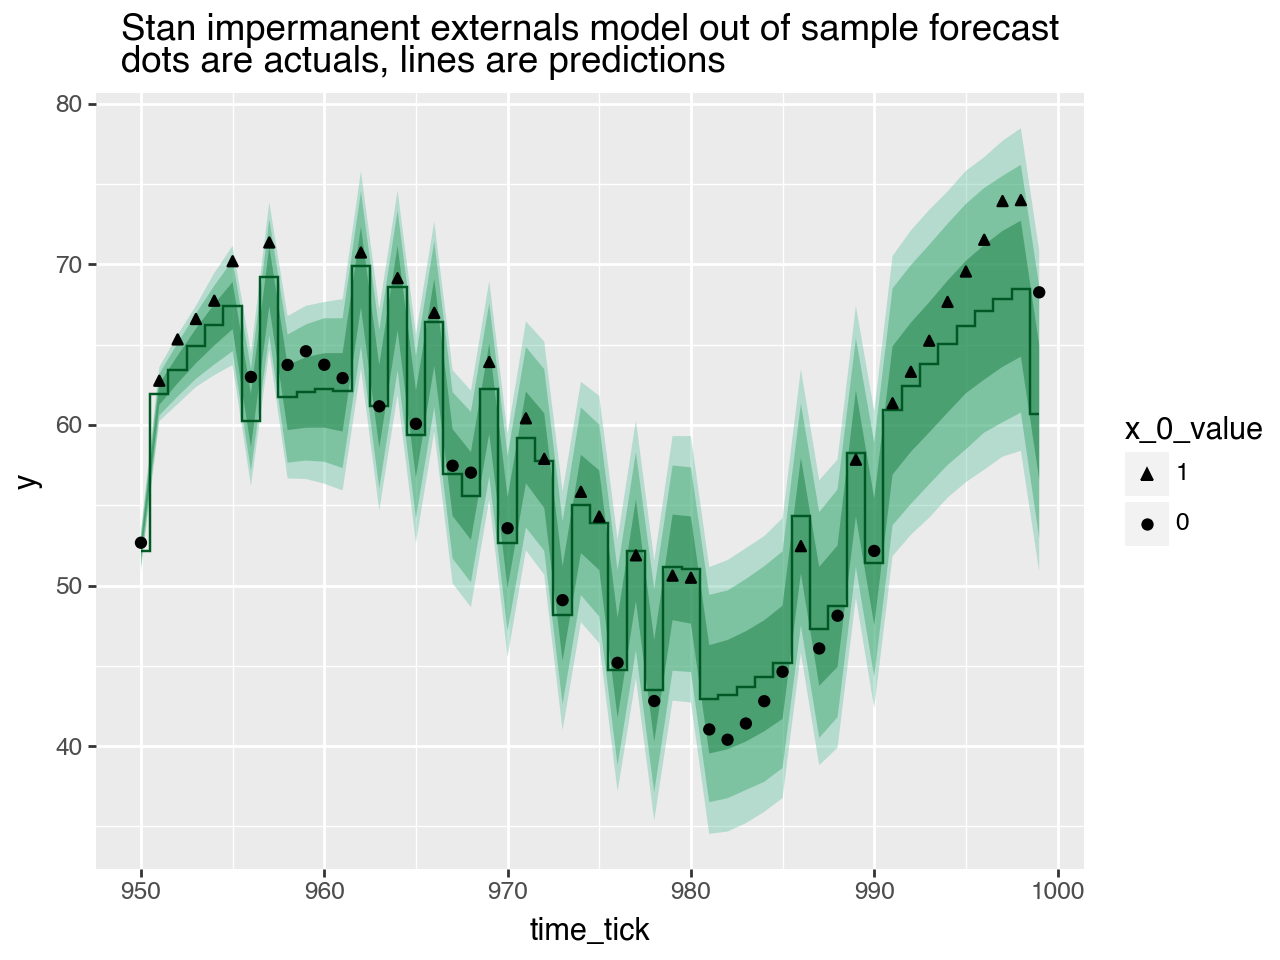

In [24]:
# plot inference over time
plt_i, s_frame_i = plot_forecast(
    forecast_soln_i, 
    d_test,
    model_name='Stan impermanent externals model',
    enforce_nonnegative=True,
)
plt_i.show()


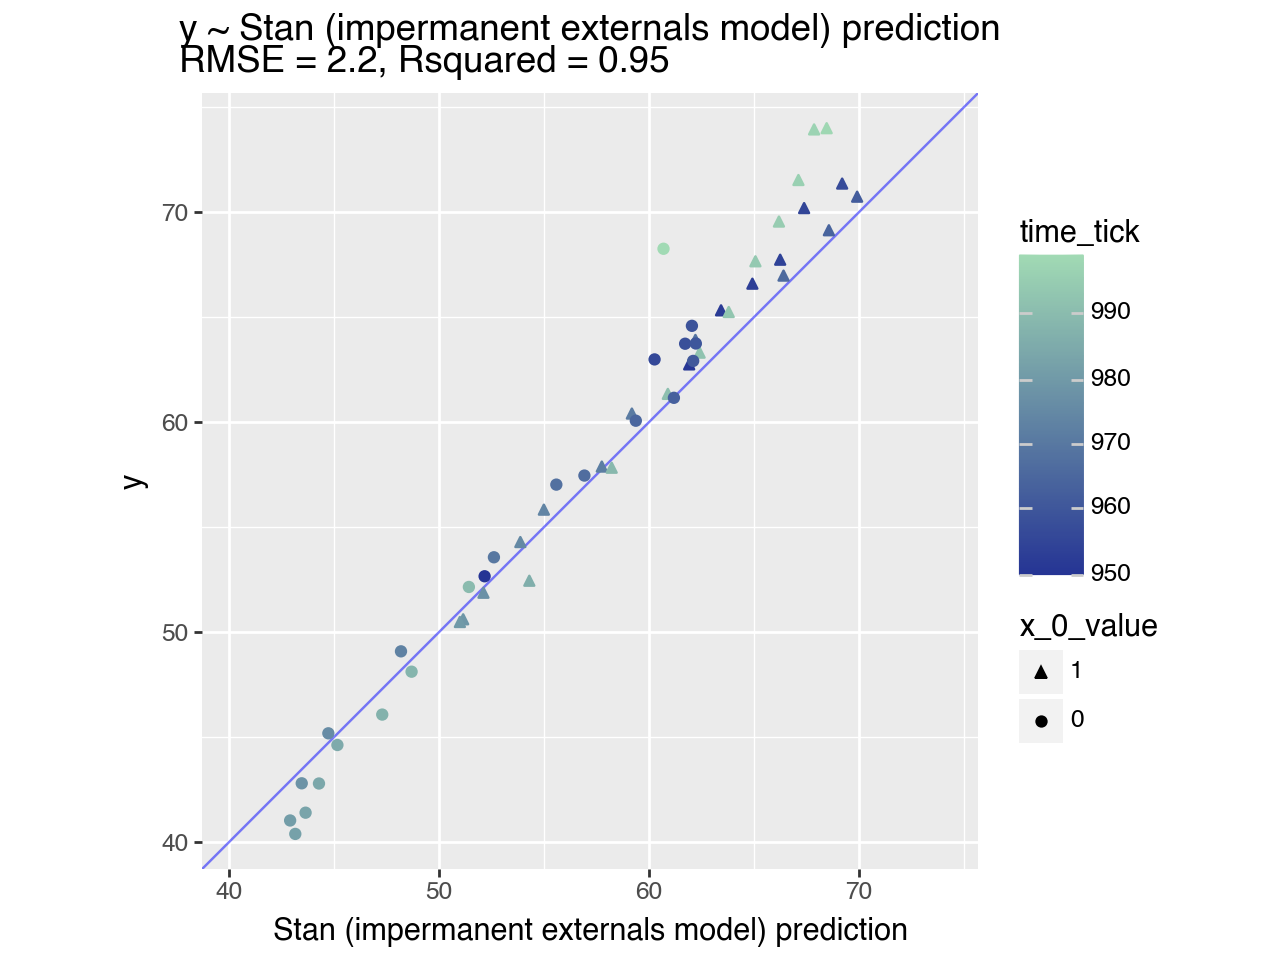

In [25]:
# plot quality of fit as a scatter plot
d_test['Stan (impermanent externals model) prediction'] = extract_sframe_result(s_frame_i)
plot_model_quality(
    d_test=d_test,
    result_name='Stan (impermanent externals model) prediction',
)


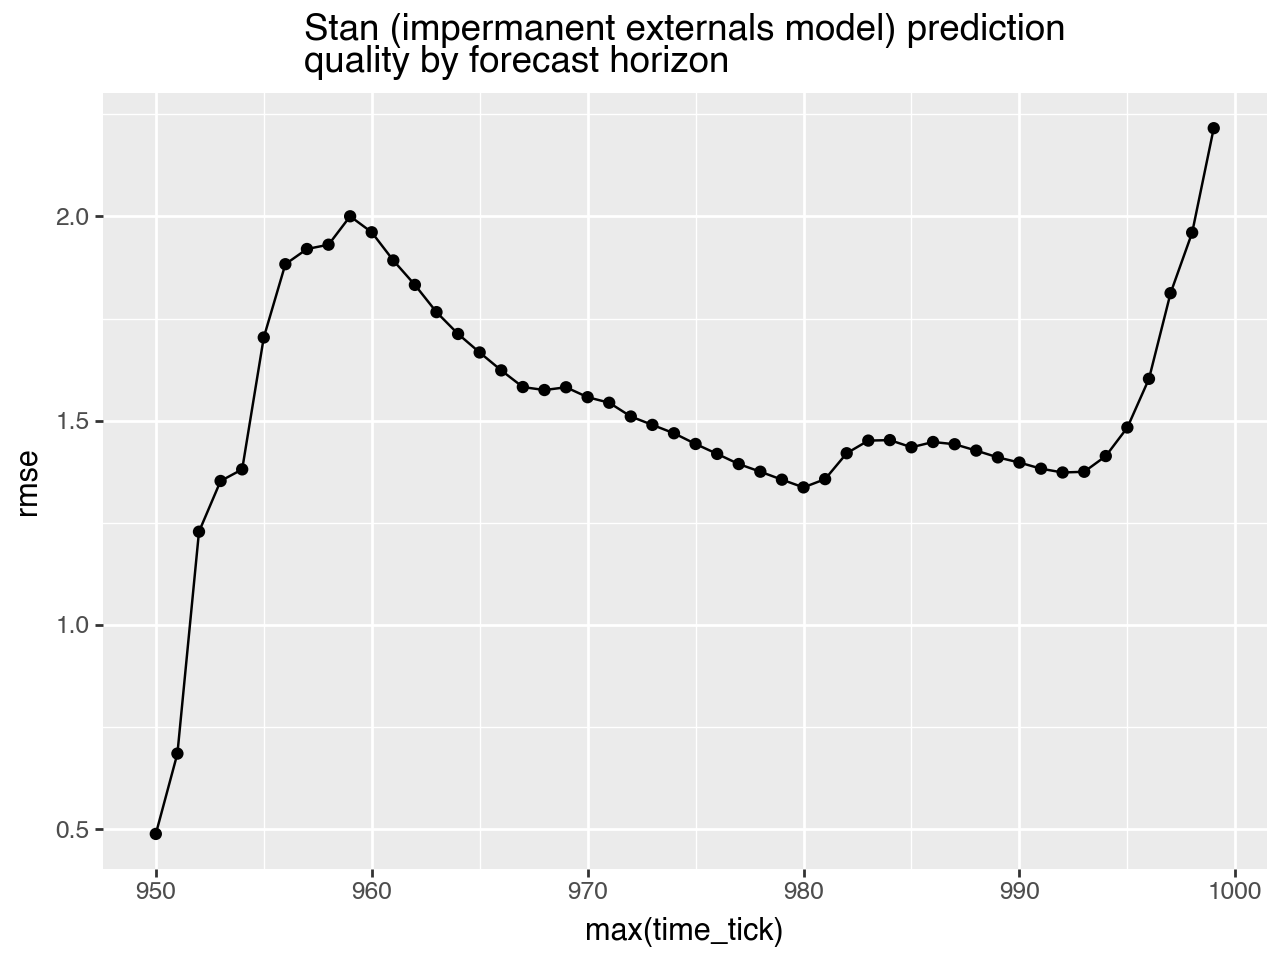

In [26]:
# plot quality as a function of how far out we are predicting
plot_model_quality_by_prefix(
    s_frame=s_frame_i,
    d_test=d_test,
    result_name='Stan (impermanent externals model) prediction',
)


The model identifies 3 very valuable things:

  * Estimates of the model parameters: 
     * `b_auto_intercept`
     * `b_auto[0]`
     * `b_auto[1]`
     * `b_x_imp[0]`
  * Projections or applications of the model for future `time_tick`s 950 through 999.
  * Good inferences of the most recent unobserved states `y_auto[948]` and `y_auto[949]` in the training period.

The third item provides a much more useful estimate of then hidden state (based on evaluation of trajectories through the entire training period) than the simple single point estimate `y_auto[i] ~ y[i] - b_x_impl[0] - x_0[i]`. One can evolve estimates forward from these inferences, and that is not always the case for the simple expected value estimates.

The issue with the simple (or naive) estimates being: they are single value point estimates, not necessarily compatible with *any* of the estimate sampling trajectories. Plugging in the naive estimates often does not allow one to evolve the prediction trajectories forward in a sensible manner. The detailed estimates from the Stan sampler do allow such forward evolution of estimates (either inside the Stan sampler as shown, or as a simple external procedure).


Stan's estimated unobserved state (prediction minus external influences) is close to the data in the training period and the evolves forward into the test or application period.

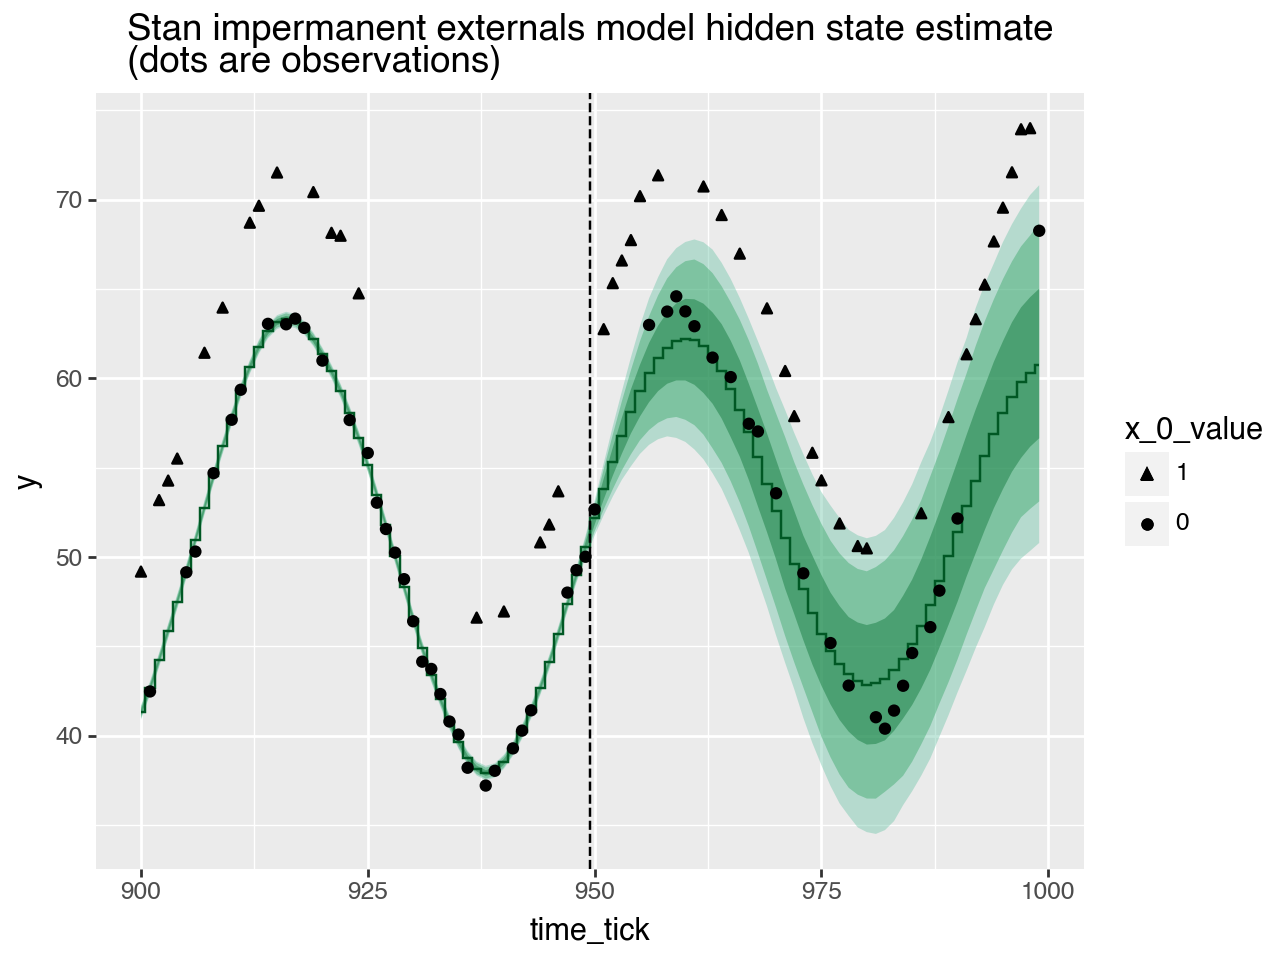

In [27]:
# plot hidden state estimate
plot_hidden_state_estimate(
    forecast_soln_i,
    d_train=d_train,
    d_test=d_test,
    model_name='Stan impermanent externals model',
    enforce_nonnegative=True,
)


For this model the future state is determined by the model parameters plus the last hidden state estimated int the training period. The distribution of these estimates across different samples is shown here. Notice they are not the same as the simple "point expected value" estimates one might try by hand (vertical lines in the plot).

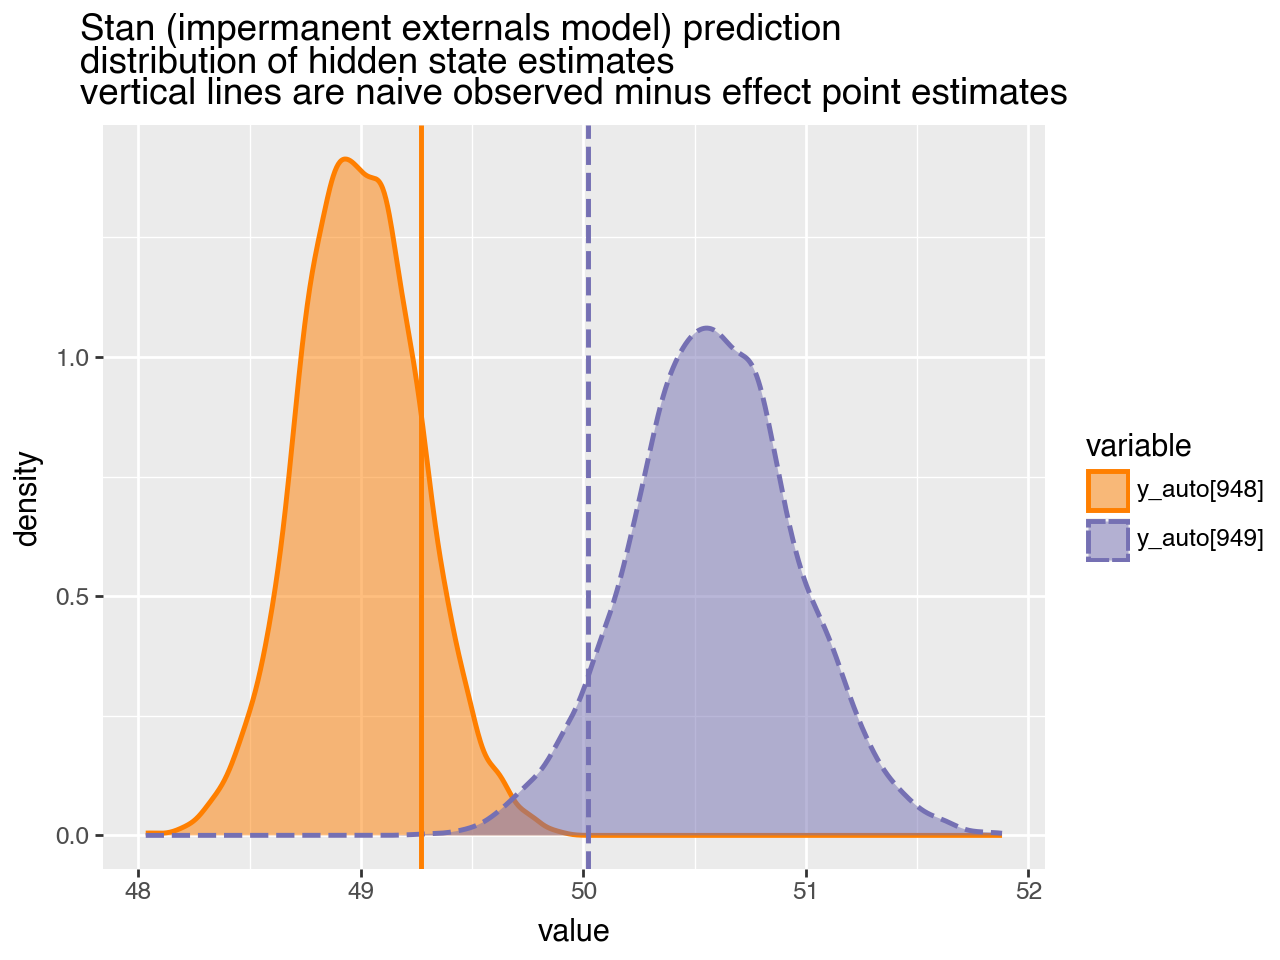

In [28]:
plot_recent_state_distribution(
    d_train=d_train,
    forecast_soln=forecast_soln_i,
    generating_lags=generating_lags,
    result_name='Stan (impermanent externals model) prediction',
)


### One Step Expected Value Forward Evolution


In this sub-section we try the traditional time series of estimating the expected value of future hidden state by plugging in our own estimates as the expected value.  Please see Box, Jenkins, Reinsel, *Time Series Analysis*, 4th Edition, Wiley section 5.1.2 "Three Basic Forms for the Forecast" pp. 142-143 for the details.

#### Stepping forward the Stan hidden state estimates

First we try stepping the Stan hidden state estimates forward. We expect this to work, and it does work well. Though, in general, it may be safer to use Stan's own inferred hidden trajectories.

In [29]:
# extract last estimated training state and parameters
recent_indexes = list(range(d_train.shape[0] - np.max(generating_lags), d_train.shape[0]))
fwd_est = forecast_soln_i.loc[
    :,
    ['b_auto_intercept', 'b_auto[0]', 'b_auto[1]', 'b_x_imp[0]']
    + [f'y_auto[{i}]' for i in recent_indexes]
].reset_index(drop=True, inplace=False)

fwd_est

,b_auto_intercept,b_auto[0],b_auto[1],b_x_imp[0],y_auto[948],y_auto[949]
0,1.23340,1.96699,-0.990761,8.17606,48.7407,50.2947
1,1.24492,1.96750,-0.991304,8.11490,49.3231,50.7669
2,1.24375,1.97292,-0.996609,8.12353,48.6447,50.3195
3,1.21588,1.97386,-0.997263,8.13439,49.4869,50.9267
4,1.26781,1.97186,-0.996116,8.07895,48.4236,50.1279
...,...,...,...,...,...,...
3995,1.28335,1.97097,-0.995615,8.12318,48.5406,50.1690
3996,1.22903,1.96706,-0.990639,8.09962,48.7987,50.7400
3997,1.23242,1.97030,-0.993902,8.08846,49.0320,50.0641
3998,1.24020,1.97160,-0.995407,8.13262,48.9496,50.6600


In [30]:
# evolve estimate forward with usual time series "plug in expected value of 1 step"
fwd_est = dict(fwd_est)
idx = d_train.shape[0]
for test_i in range(d_test.shape[0] + 1):
    e_state = fwd_est['b_auto_intercept']
    for lag_i, lag_dist in enumerate(generating_lags):
        e_state = e_state + fwd_est[f'b_auto[{lag_i}]'] * fwd_est[f'y_auto[{idx - lag_dist }]']
    fwd_est[f'y_auto[{idx}]'] = e_state
    idx = idx + 1
fwd_est = pd.DataFrame(fwd_est)

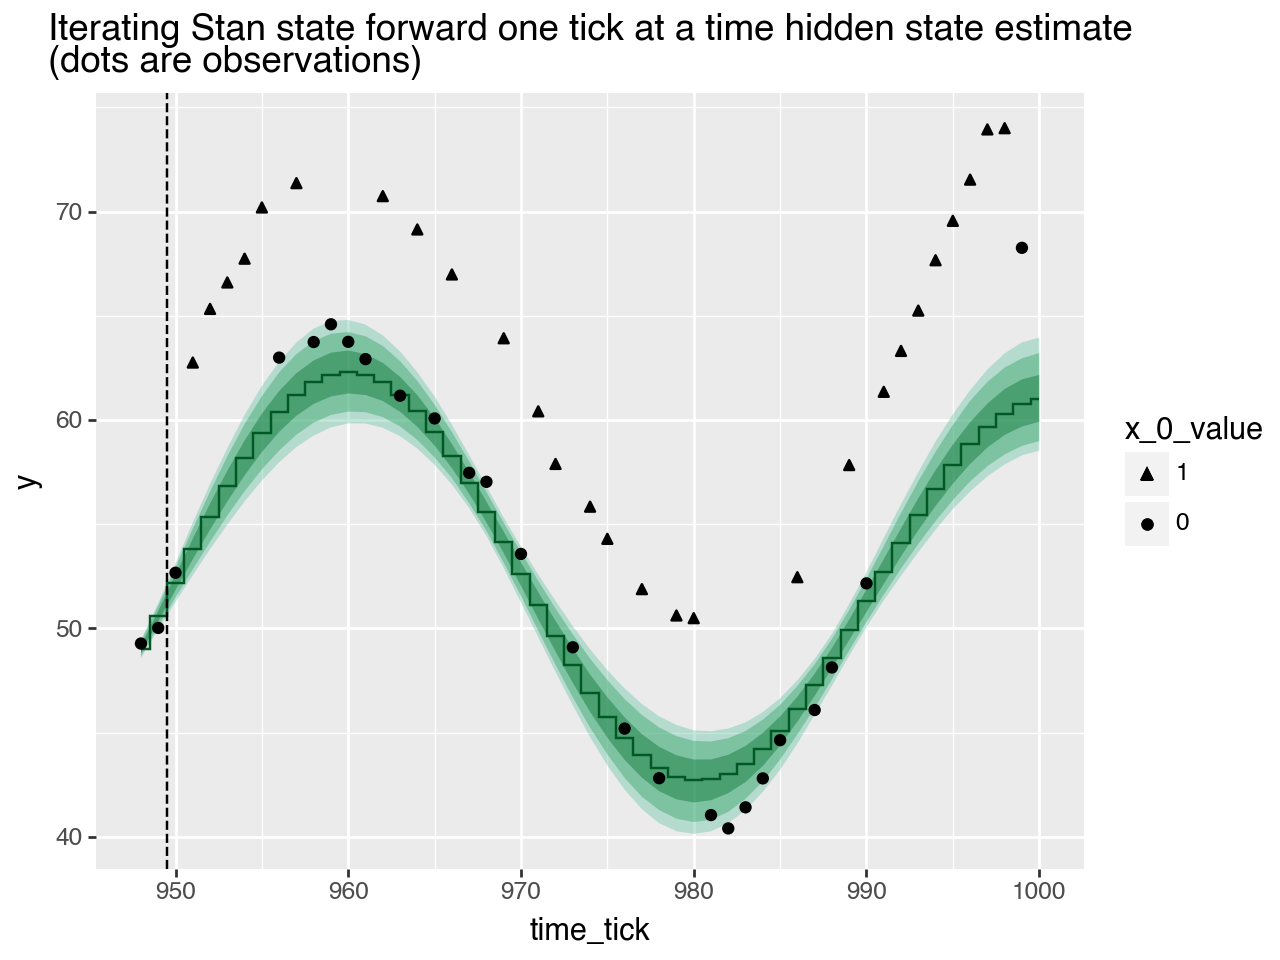

In [31]:
# plot hidden state estimate
plot_hidden_state_estimate(
    fwd_est,
    d_train=d_train.loc[recent_indexes, :].reset_index(drop=True, inplace=False),
    d_test=d_test,
    model_name='Iterating Stan state forward one tick at a time',
    enforce_nonnegative=True,
)

In [32]:
# add in external regressors
new_ys = dict()
for test_idx in range(d_test.shape[0]):
    new_ys[f'y_future[{test_idx}]'] = (
        fwd_est[f'y_auto[{d_train.shape[0] + test_idx}]'] 
        + d_test.loc[test_idx, 'x_0'] * fwd_est[f'b_x_imp[0]']
    )
fwd_est = pd.concat([fwd_est, pd.DataFrame(new_ys)], axis=1)

In [33]:
fwd_est

,b_auto_intercept,b_auto[0],b_auto[1],b_x_imp[0],y_auto[948],y_auto[949],y_auto[950],y_auto[951],y_auto[952],y_auto[953],...,y_future[40],y_future[41],y_future[42],y_future[43],y_future[44],y_future[45],y_future[46],y_future[47],y_future[48],y_future[49]
0,1.23340,1.96699,-0.990761,8.17606,48.7407,50.2947,51.872187,53.435446,54.947449,56.372726,...,51.043166,60.524896,61.807518,63.036817,64.184064,65.222745,66.129173,66.883022,67.467784,59.695060
1,1.24492,1.96750,-0.991304,8.11490,49.3231,50.7669,52.234609,53.691083,55.101749,56.433425,...,51.492904,60.836820,62.045075,63.203989,64.286404,65.267221,66.123974,66.837349,67.391612,59.660051
2,1.24375,1.97292,-0.996609,8.12353,48.6447,50.3195,52.040352,53.766335,55.456544,57.071062,...,50.863494,60.597588,62.203382,63.766383,65.249710,66.618495,67.840702,68.887873,69.735798,62.241534
3,1.21588,1.97386,-0.997263,8.13439,49.4869,50.9267,52.386602,53.832384,55.230250,56.547616,...,50.975675,60.490179,61.857112,63.178911,64.424766,65.565727,66.575379,67.430454,68.111363,60.468256
4,1.26781,1.97186,-0.996116,8.07895,48.4236,50.1279,51.877488,53.629751,55.342174,56.973377,...,51.474357,61.176724,62.773705,64.305618,65.735557,67.029234,68.155798,69.088572,69.805684,62.211627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.28335,1.97097,-0.995615,8.12318,48.5406,50.1690,51.837194,53.503896,55.128036,56.669773,...,51.945559,61.594162,63.078455,64.485216,65.780116,66.931733,67.912313,68.698440,69.271592,61.495399
3996,1.22903,1.96706,-0.990639,8.09962,48.7987,50.7400,52.695759,54.619727,56.466836,58.194253,...,51.303314,61.015049,62.593410,64.101117,65.503281,66.767829,67.866231,68.774144,69.471944,61.845524
3997,1.23242,1.97030,-0.993902,8.08846,49.0320,50.0641,51.140713,52.236158,53.324466,54.379992,...,50.500935,59.544772,60.512271,61.468983,62.392395,63.260914,64.054376,64.754513,65.345367,57.725202
3998,1.24020,1.97160,-0.995407,8.13262,48.9496,50.6600,52.396682,54.118179,55.783577,57.353487,...,51.358182,61.071754,62.625322,64.114647,65.504567,66.762449,67.858954,68.768717,69.470938,61.817233


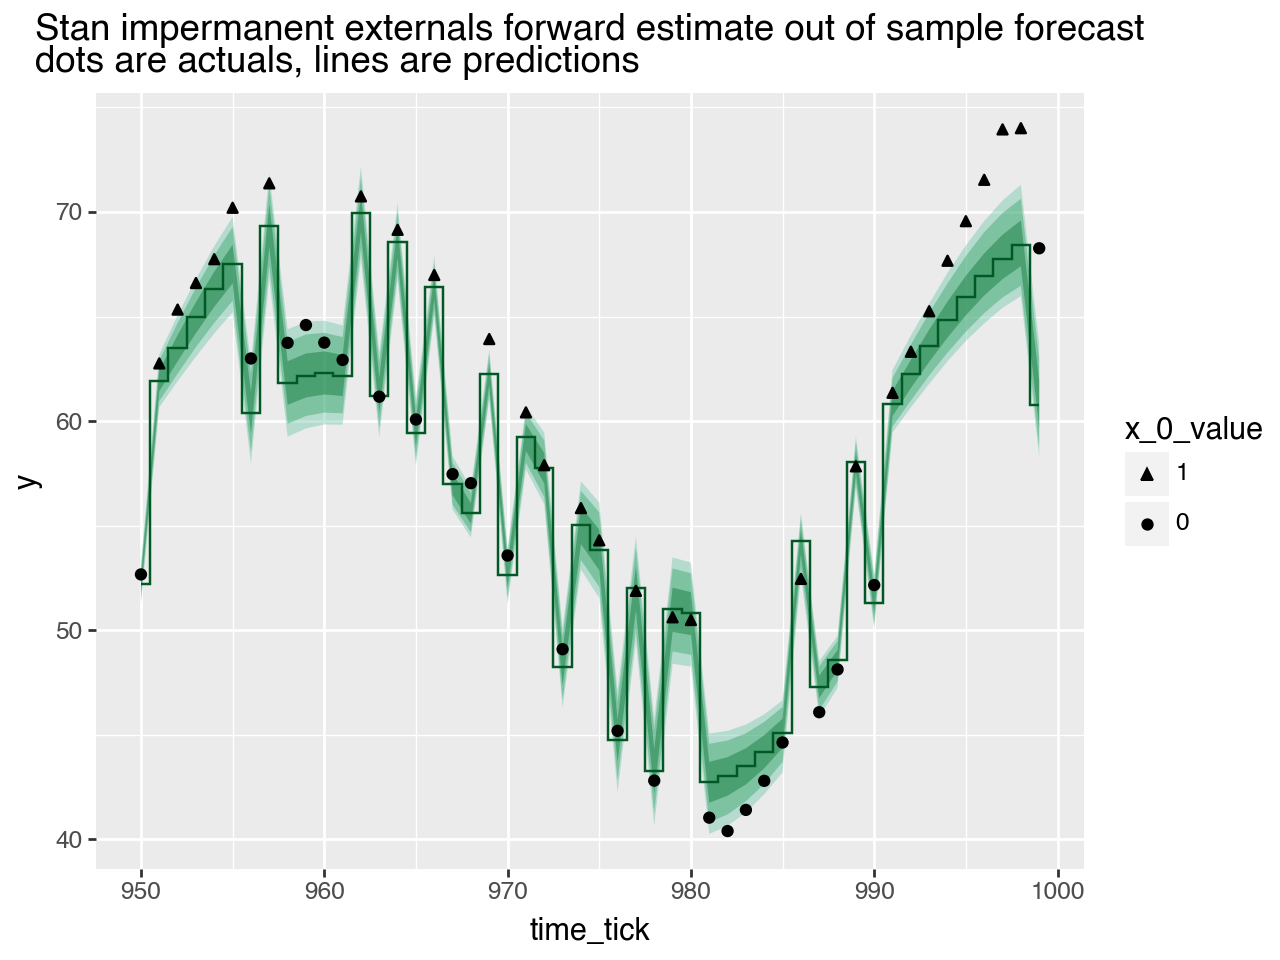

In [34]:
# plot fit over time
plt_if, s_frame_if = plot_forecast(
    fwd_est, 
    d_test,
    model_name='Stan impermanent externals forward estimate',
    enforce_nonnegative=True,
)
plt_if.show()

In [35]:
d_test['Stan (impermanent externals step forward) prediction'] = np.array(fwd_est.loc[
    :, 
    [c for c in fwd_est.columns if c.startswith('y_future')]].quantile(0.5))

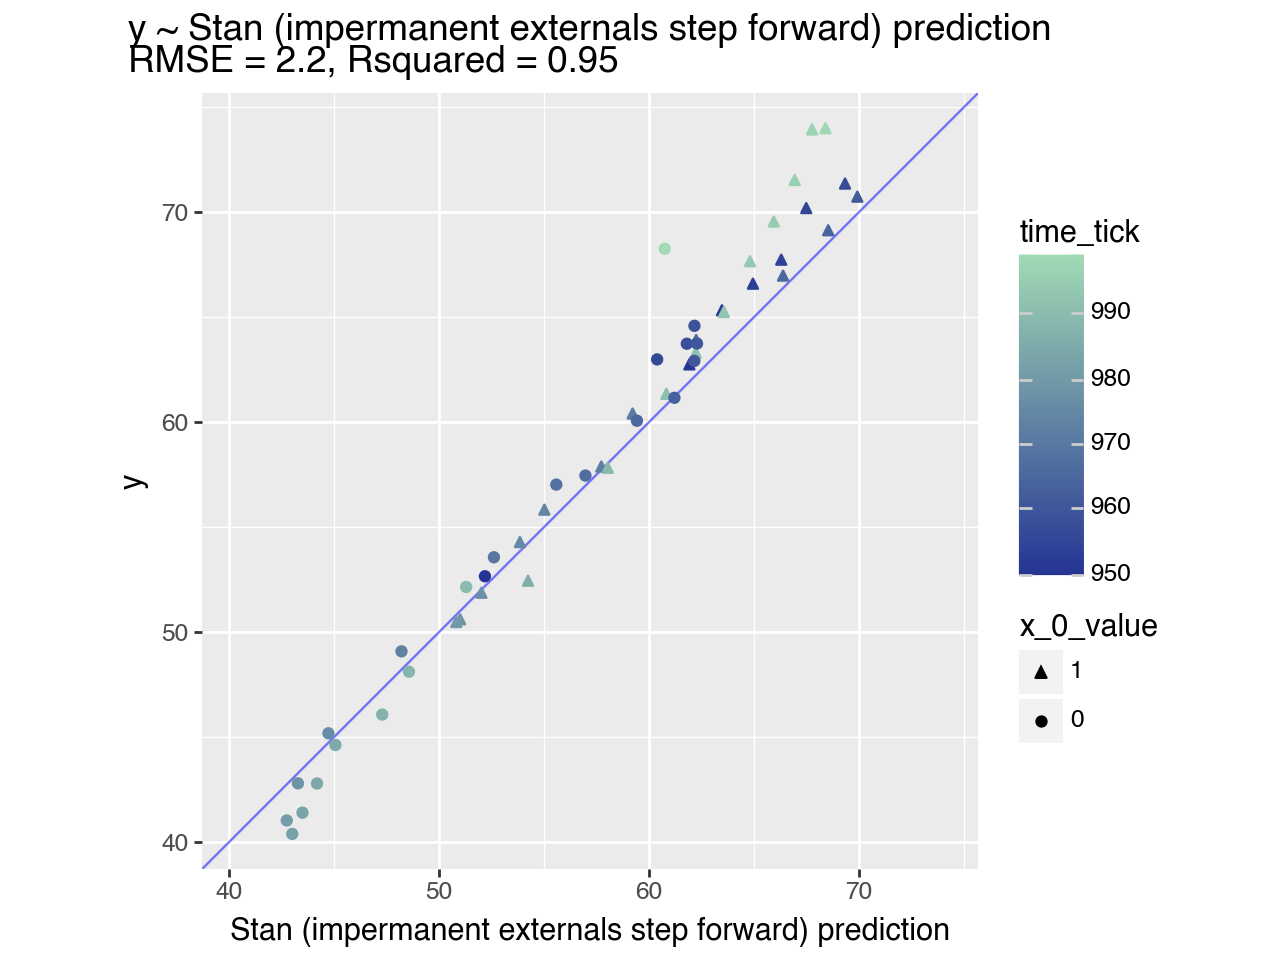

In [36]:
# plot quality of fit as a scatter plot
plot_model_quality(
    d_test=d_test,
    result_name='Stan (impermanent externals step forward) prediction',
)

What we see is: in this case the "step forward by plugging in expected values" (starting from the Stan hidden state estimates) works very well.

#### Stepping "peel off the externals" hidden state estimates forward

In this sub-section we ignore the Stan hidden state estimates and try stepping an estimate of the form `y_auto ~ y - external regressor effects` forward. It turns out this does not work. 

The problem being: while observations are unbiased estimates of the hidden state, they are not necessarily jointly likely when considered with the estimated auto-regressive coefficients. Thus in turn means: combining the two may generate implausible (and wrong) forward trajectory estimates. We will illustrate this failing here. 

The take away is: estimate hidden state and hidden parameters jointly. Do not expect good results pasting different estimates together.

In [37]:
# extract training parameters, but take state from recent training observation (not inference)
recent_indexes = list(range(d_train.shape[0] - np.max(generating_lags), d_train.shape[0]))
fwd_est_strip = forecast_soln_i.loc[
    :,
    ['b_auto_intercept', 'b_auto[0]', 'b_auto[1]', 'b_x_imp[0]']
].reset_index(drop=True, inplace=False)
for i in recent_indexes:
    fwd_est_strip[f'y_auto[{i}]'] = d_train.loc[i, 'y'] - d_train.loc[i, 'x_0'] * fwd_est_strip['b_x_imp[0]']

fwd_est_strip

,b_auto_intercept,b_auto[0],b_auto[1],b_x_imp[0],y_auto[948],y_auto[949]
0,1.23340,1.96699,-0.990761,8.17606,49.27092,50.019818
1,1.24492,1.96750,-0.991304,8.11490,49.27092,50.019818
2,1.24375,1.97292,-0.996609,8.12353,49.27092,50.019818
3,1.21588,1.97386,-0.997263,8.13439,49.27092,50.019818
4,1.26781,1.97186,-0.996116,8.07895,49.27092,50.019818
...,...,...,...,...,...,...
3995,1.28335,1.97097,-0.995615,8.12318,49.27092,50.019818
3996,1.22903,1.96706,-0.990639,8.09962,49.27092,50.019818
3997,1.23242,1.97030,-0.993902,8.08846,49.27092,50.019818
3998,1.24020,1.97160,-0.995407,8.13262,49.27092,50.019818


In [38]:
# evolve estimate forward with usual time series "plug in expected value of 1 step"
fwd_est_strip = dict(fwd_est_strip)
idx = d_train.shape[0]
for test_i in range(d_test.shape[0] + 1):
    e_state = fwd_est_strip['b_auto_intercept']
    for lag_i, lag_dist in enumerate(generating_lags):
        e_state = e_state + fwd_est_strip[f'b_auto[{lag_i}]'] * fwd_est_strip[f'y_auto[{idx - lag_dist }]']
    fwd_est_strip[f'y_auto[{idx}]'] = e_state
    idx = idx + 1
fwd_est_strip = pd.DataFrame(fwd_est_strip)

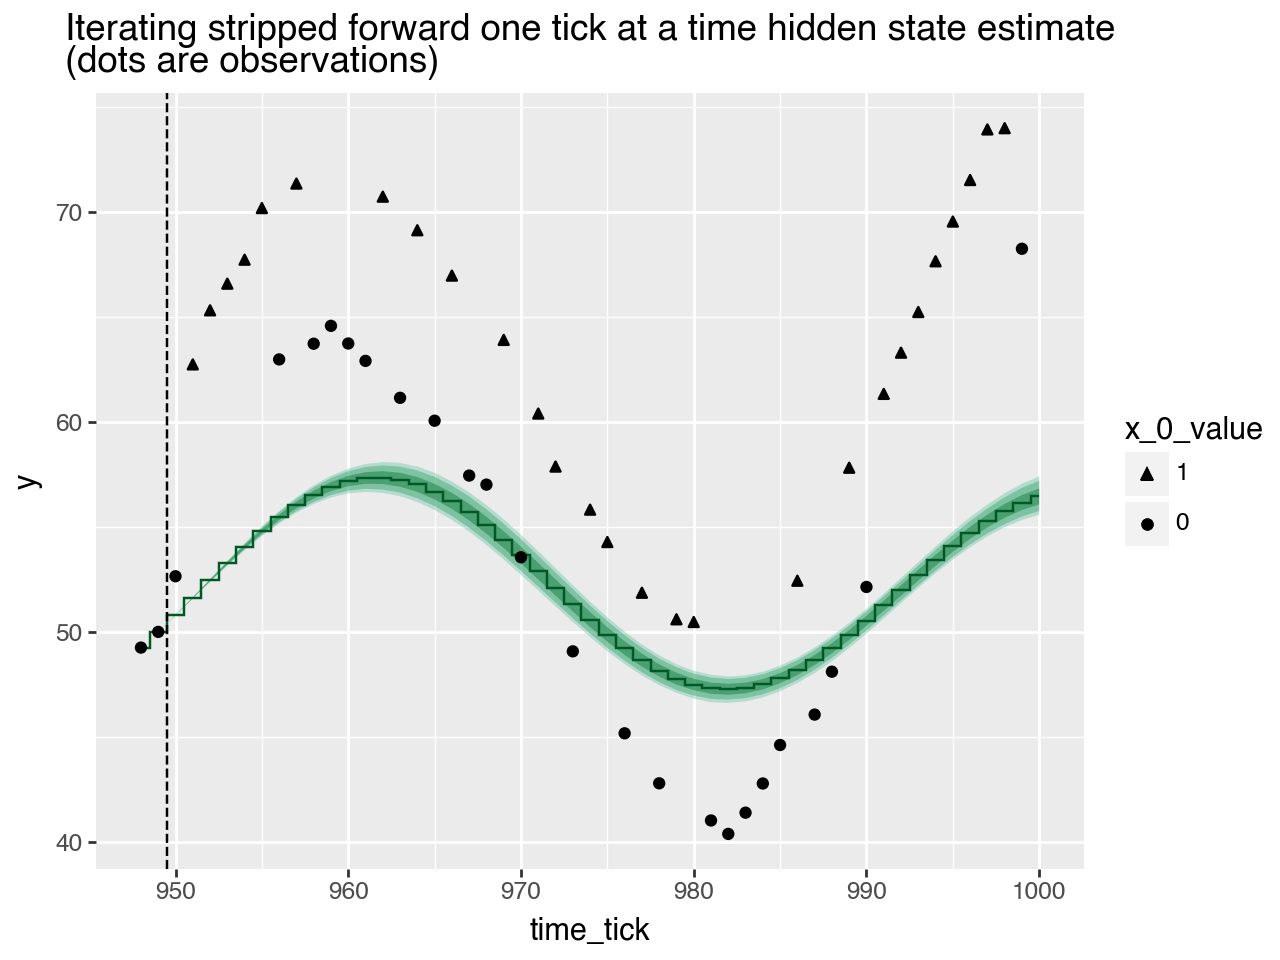

In [39]:
# plot hidden state estimate
plot_hidden_state_estimate(
    fwd_est_strip,
    d_train=d_train.loc[recent_indexes, :].reset_index(drop=True, inplace=False),
    d_test=d_test,
    model_name='Iterating stripped forward one tick at a time',
    enforce_nonnegative=True,
)

Notice in this case, this does *not* yield a good estimate of the future hidden state (which should be near circles in the graph). This is a common issue with estimates: they must be formed jointly to have properties similar to properties ascribed to the unobserved hidden values. In our case stripping off the effect does give an unbiased estimate of the hidden state. However, it gives one that is not compatible with auto-regressive coefficient estimates in the long run.

This illustrates the following. One can reliably estimate out many steps by re-applying single time step estimates. However, this requires estimates of the hidden state that are jointly plausible with estimate system parameters. Otherwise error compounds and gives an incorrect long-term trajectory (as we saw above).

## Bayesian method without external regressors


Let's get back to overall methodology.

As a lower-bound on model quality we can try a Bayesian (Stan) model without external regressors.


In [40]:
# define a Stan model without external predictors
stan_model_with_forecast_0, stan_model_with_forecast_src_0 = define_Stan_model_with_forecast_period(
    application_lags=generating_lags,
    n_impermanent_external_regressors=0,
    n_durable_external_regressors=0,
)


In [41]:
# show the model specification
print(stan_model_with_forecast_src_0)



data {
  int<lower=1> N_y_observed;                  // number of observed y outcomes
  int<lower=1> N_y_future;                    // number of future outcomes to infer
  vector[N_y_observed] y_observed;            // observed outcomes
}
parameters {
  real b_auto_intercept;                      // auto-regress intercept
  vector[2] b_auto;                           // auto-regress coefficients
  vector[N_y_future] y_future;                // to be inferred future state
  vector[N_y_observed + N_y_future] y_auto;   // unobserved auto-regressive state
  real<lower=0> b_var_y_auto;                 // presumed y_auto (durable) noise variance
  real<lower=0> b_var_y;                      // presumed y (impermanent) noise variance
}
transformed parameters {
        // y_observed and y_future in one notation (for subscripting)
  vector[N_y_observed + N_y_future] y;        
  y[1:N_y_observed] = y_observed;
  y[(N_y_observed + 1):(N_y_observed + N_y_future)] = y_future;
}
model {
  b_var_y_

In [42]:
# sample from Stan model solutions
forecast_soln_0 = solve_forecast_by_Stan(
    model=stan_model_with_forecast_0, 
    d_train=d_train,
    d_apply=d_test,
    )


In [43]:
# summarize parameter estimates
forecast_soln_0.loc[
    :,
    [c for c in forecast_soln_0 if c.startswith('b_')]
].median()


b_auto_intercept    1.318730
b_auto[0]           1.969700
b_auto[1]          -0.993726
b_var_y_auto        0.210246
b_var_y             3.952560
dtype: float64

In [44]:
# show original generative parameters
generating_params


{'b_auto_intercept': 1.2804125781056719,
 'b_auto': (1.9753766811902755, -1),
 'b_x': (8.1,)}

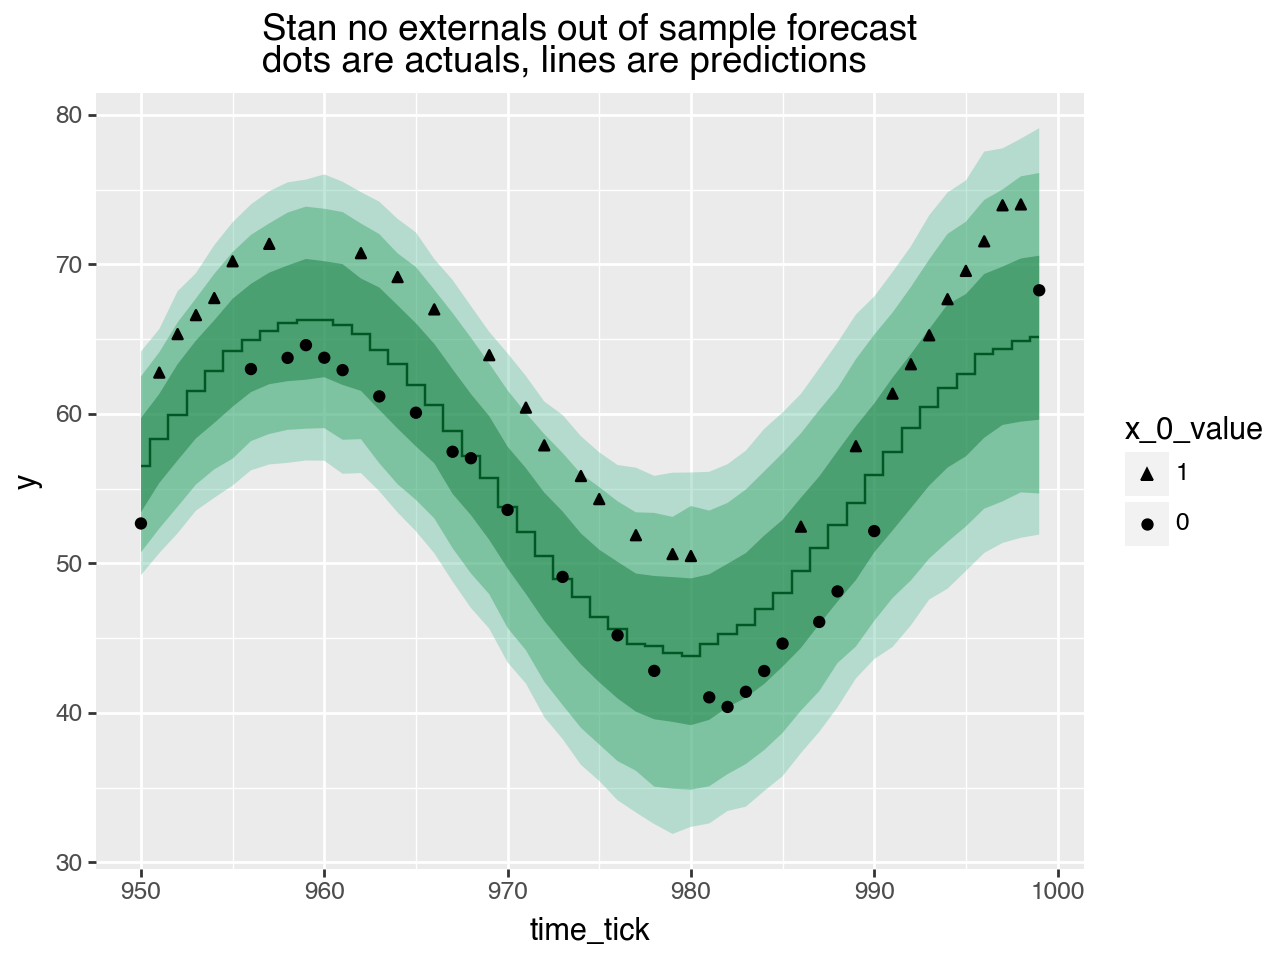

In [45]:
# plot fit over time
plt_0, s_frame_0 = plot_forecast(
    forecast_soln_0, 
    d_test,
    model_name='Stan no externals',
    enforce_nonnegative=True,
)
plt_0.show()


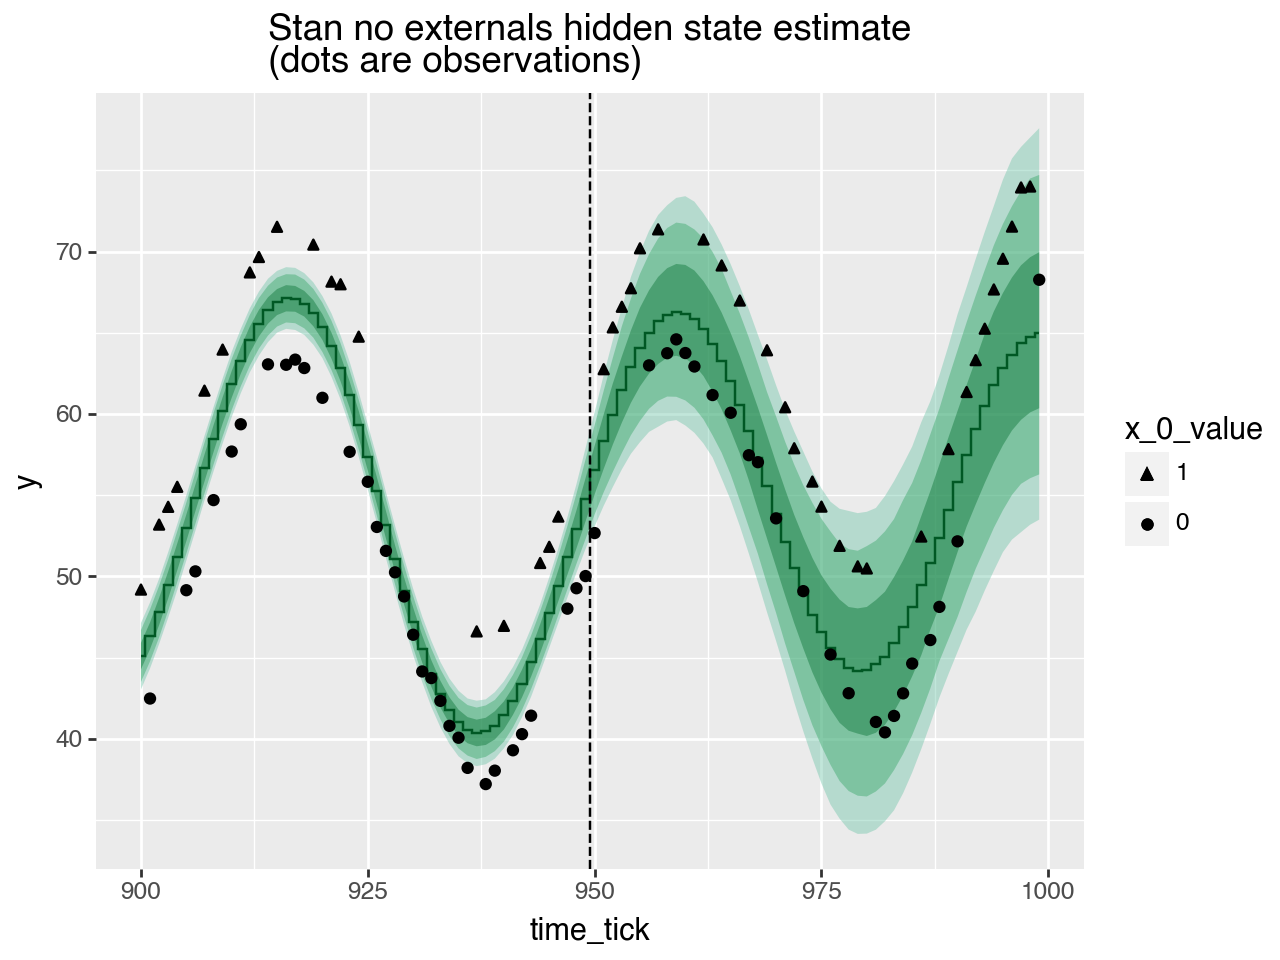

In [46]:
# plot hidden state estimate
plot_hidden_state_estimate(
    forecast_soln_0,
    d_train=d_train,
    d_test=d_test,
    model_name='Stan no externals',
    enforce_nonnegative=True,
)


Notice both the predictions and estimated hidden state are "middle of the road" estimates again.

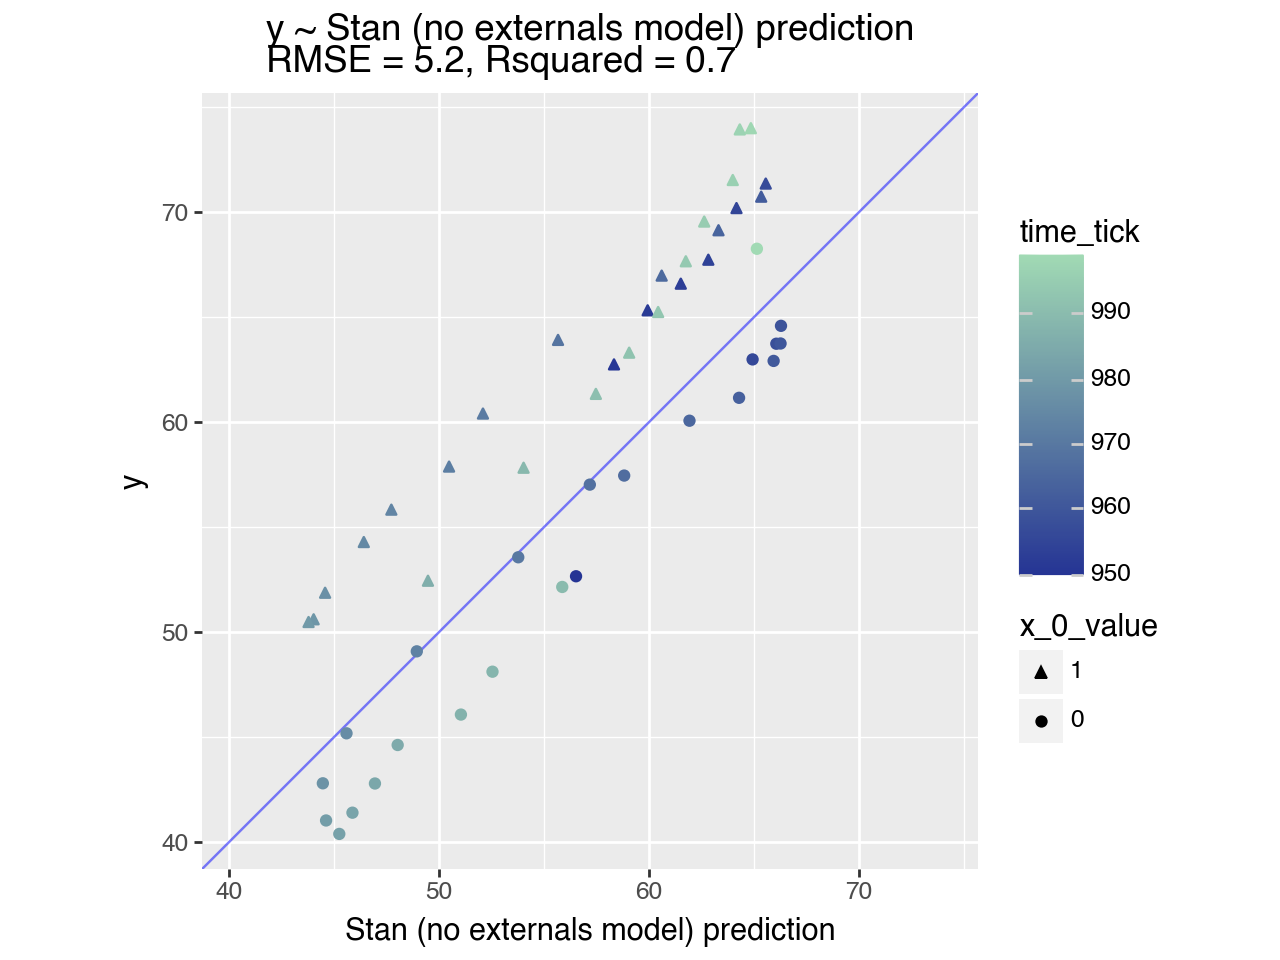

In [47]:
# plot quality of fit as a scatter plot
d_test['Stan (no externals model) prediction'] = extract_sframe_result(s_frame_0)
plot_model_quality(
    d_test=d_test,
    result_name='Stan (no externals model) prediction',
)


## Bayesian method, with less positive inductive bias (fewer hints)

Finally we try a Bayesian model with the possibility of the external regressor having separate impermanent and durable contributions. The hope would be the data can identify the system for us (so we don't have to specify it). However (as ARMAX literature rightly notes), too many systems having identical auto-regressive structure makes the system hard to identify from data. And it turns out this is not the way to go: a good (and parsimonious) model specification is in fact an big advantage.


In [48]:
# define a Stan model for both parameters and future predictions
stan_model_with_forecast_c, stan_model_with_forecast_src_c = define_Stan_model_with_forecast_period(
    application_lags=generating_lags,
    n_impermanent_external_regressors=len(b_x),
    n_durable_external_regressors=len(b_x),
)


In [49]:
# show the model specification
print(stan_model_with_forecast_src_c)



data {
  int<lower=1> N_y_observed;                  // number of observed y outcomes
  int<lower=1> N_y_future;                    // number of future outcomes to infer
  vector[N_y_observed] y_observed;            // observed outcomes
  vector[N_y_observed + N_y_future] x_imp_1;  // observed impermanent external regressor
  vector[N_y_observed + N_y_future] x_dur_1;  // observed durable external regressor
}
parameters {
  real b_auto_intercept;                      // auto-regress intercept
  vector[2] b_auto;                           // auto-regress coefficients
  vector[1] b_x_imp;                          // impermanent external regressor coefficients
  vector[1] b_x_dur;                          // durable external regressor coefficients
  vector[N_y_future] y_future;                // to be inferred future state
  vector[N_y_observed + N_y_future] y_auto;   // unobserved auto-regressive state
  real<lower=0> b_var_y_auto;                 // presumed y_auto (durable) noise vari

In [50]:
# sample from Stan model solutions
forecast_soln_c = solve_forecast_by_Stan(
    model=stan_model_with_forecast_c, 
    d_train=d_train,
    d_apply=d_test,
    impermanent_external_regressors=['x_0'],
    durable_external_regressors=['x_0'],
    )


In [51]:
# summarize parameter estimates
forecast_soln_c.loc[
    :,
    [c for c in forecast_soln_c if c.startswith('b_')]
].median()


b_auto_intercept    1.269240
b_auto[0]           1.968060
b_auto[1]          -0.991954
b_x_imp[0]          8.133905
b_x_dur[0]         -0.040737
b_var_y_auto        0.210651
b_var_y             0.492610
dtype: float64

In [52]:
# show original generative parameters
generating_params


{'b_auto_intercept': 1.2804125781056719,
 'b_auto': (1.9753766811902755, -1),
 'b_x': (8.1,)}

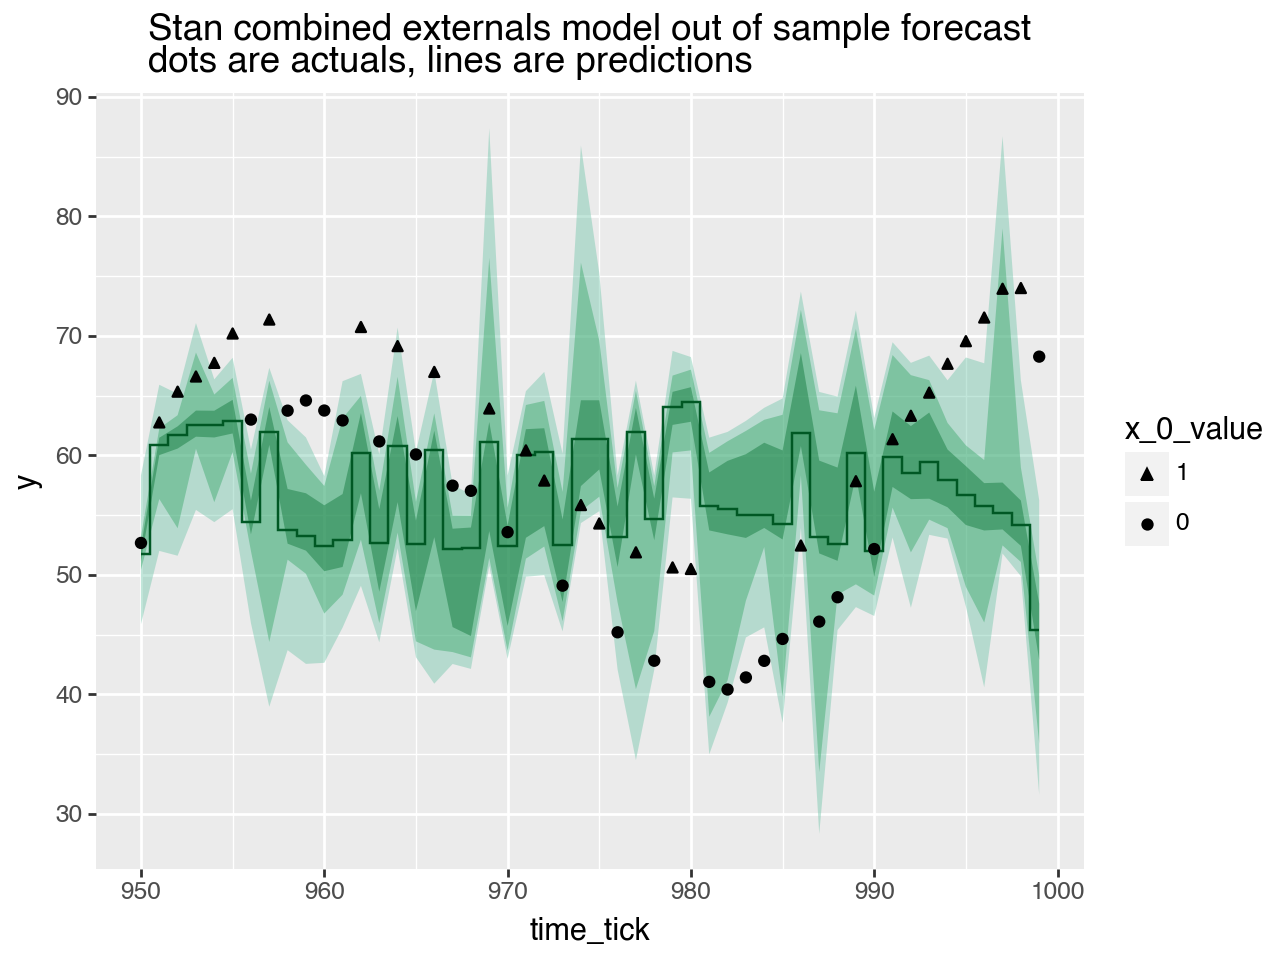

In [53]:
# plot fit over time
plt_c, s_frame_c = plot_forecast(
    forecast_soln_c, 
    d_test,
    model_name='Stan combined externals model',
    enforce_nonnegative=True,
)
plt_c.show()


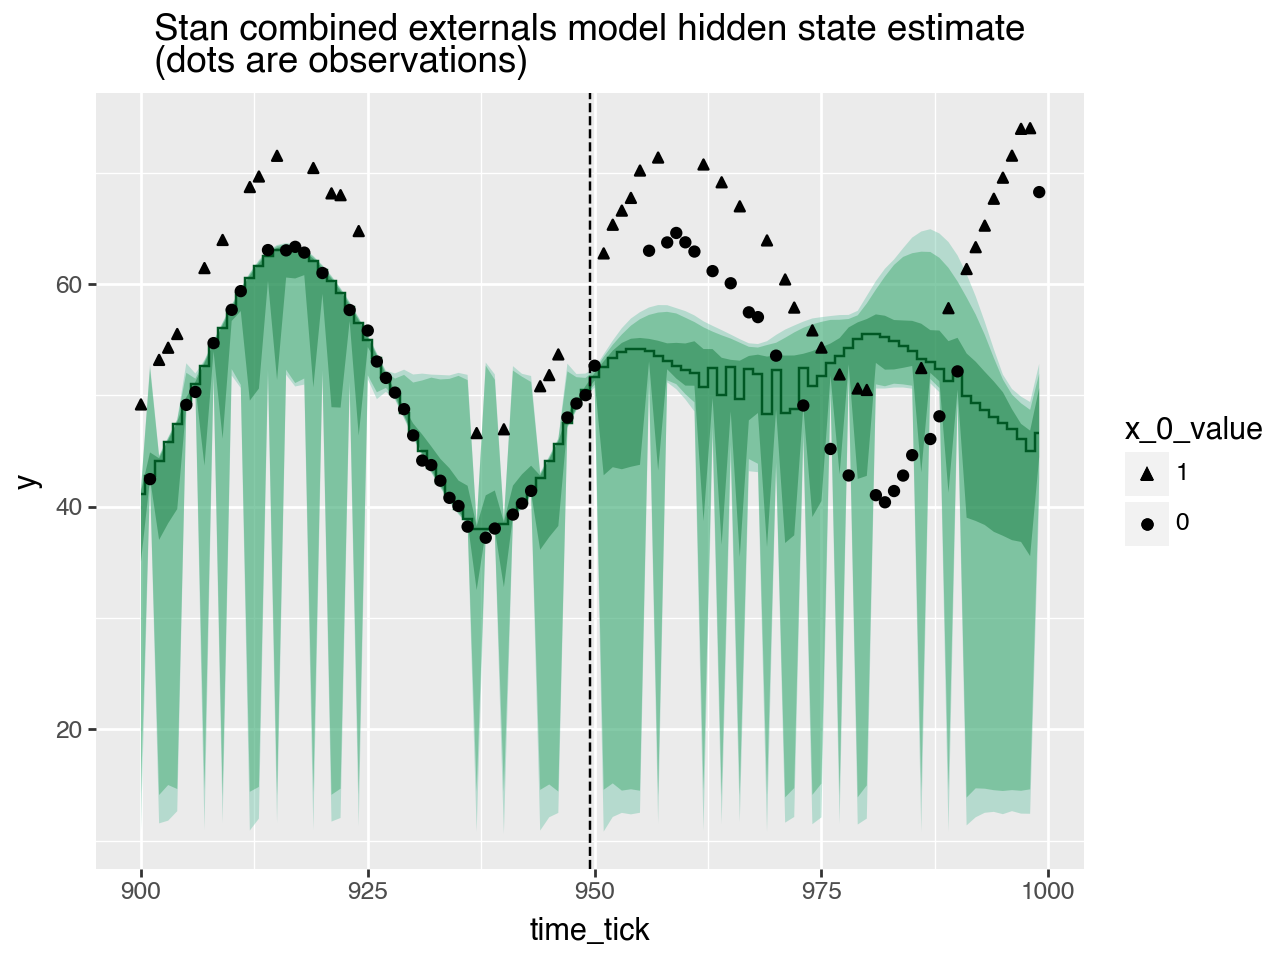

In [54]:
# plot hidden state estimate
plot_hidden_state_estimate(
    forecast_soln_c,
    d_train=d_train,
    d_test=d_test,
    model_name='Stan combined externals model',
    enforce_nonnegative=True,
)


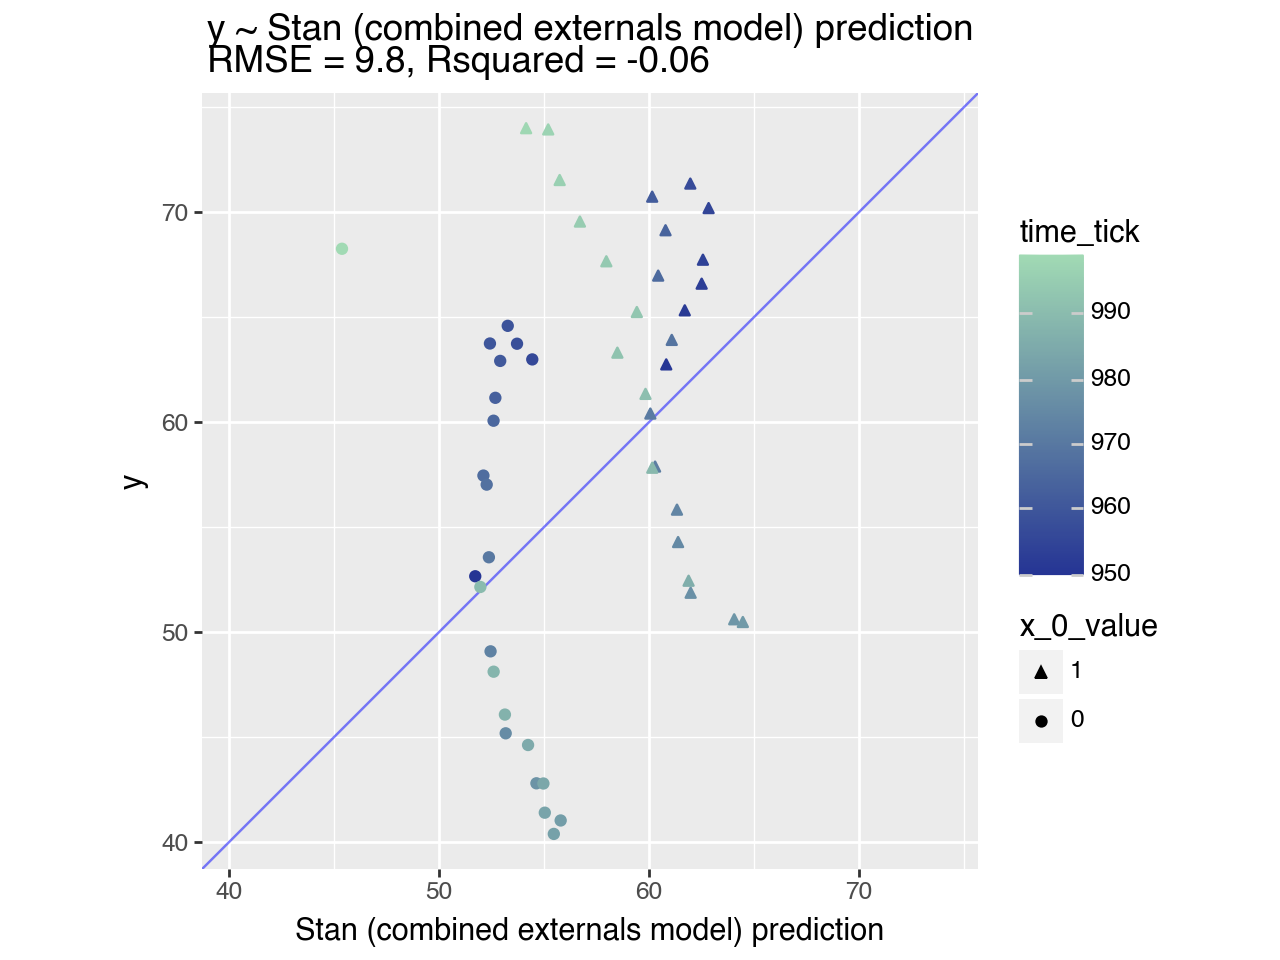

In [55]:
# plot quality of fit as a scatter plot
d_test['Stan (combined externals model) prediction'] = extract_sframe_result(s_frame_c)
plot_model_quality(
    d_test=d_test,
    result_name='Stan (combined externals model) prediction',
)


This variation did not go well. We under-specified the system, and ran into identifiability issues.

## Conclusion

And that concludes our note on modeling in the presence of external regressors. The main point is: one has to specify the structure of the regressors. Do they cause durable effects (such as marketing efforts) or do they cause impermanent effects (such as one-off sales events)? Also: we would like such specifications to be in terms familiar to domain experts, and not deep in ARMAX or transfer function terminology.